In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from LLM_utils import run_LLM

In [2]:


data_path = '/Users/riccardoconci/Local_documents/!!MIMIC'
patients_path = os.path.join(data_path,'hosp', 'patients.csv')
patients_df = pd.read_csv(patients_path)

admission_path = os.path.join(data_path,'hosp', 'admissions.csv')
admission_df = pd.read_csv(admission_path)

transfers_path = '/Users/riccardoconci/Local_documents/!!MIMIC/hosp/transfers.csv'
transfers_df = pd.read_csv(transfers_path)

disch_path = '/Users/riccardoconci/Local_documents/!!MIMIC/note/discharge.csv'
discharge_df = pd.read_csv(disch_path)[['hadm_id', 'charttime', 'text']]

merged_df = pd.merge(admission_df, patients_df, on='subject_id', how='left')
merged_df['admittime'] = pd.to_datetime(merged_df['admittime'])
merged_df['age'] = merged_df['admittime'].dt.year - merged_df['anchor_year'] + merged_df['anchor_age']


merged_df = pd.merge(merged_df, transfers_df, on=['hadm_id', 'subject_id'], how='left')

merged_df['dischtime'] = pd.to_datetime(merged_df['dischtime'])
merged_df['admittime'] = pd.to_datetime(merged_df['admittime'])
merged_df['admit_duration'] = (merged_df['dischtime'] - merged_df['admittime']).dt.total_seconds() / (3600*24)

filtered_ds = merged_df['hadm_id'].isin(discharge_df['hadm_id'])
merged_with_disch_df = merged_df.loc[filtered_ds]

merged_with_disch_df = merged_with_disch_df[merged_with_disch_df['admit_duration'] <= 10]
merged_with_disch_df = merged_with_disch_df[merged_with_disch_df['admit_duration'] >= 2]



In [3]:
merged_with_disch_df['hadm_id'].nunique()

198969

In [4]:
num_hadm_id_w_death = merged_with_disch_df[merged_with_disch_df['hospital_expire_flag'] == 1]['hadm_id'].nunique()
percent_hadm_id_w_death = num_hadm_id_w_death / merged_with_disch_df['hadm_id'].nunique()
print(f'{percent_hadm_id_w_death*100}% of hadm_ids have a death event in hospital')


1.7821871748865399% of hadm_ids have a death event in hospital


In [5]:

# Ensure datetime conversion
merged_with_disch_df['deathtime'] = pd.to_datetime(merged_with_disch_df['deathtime'], errors='coerce')
merged_with_disch_df['dod'] = pd.to_datetime(merged_with_disch_df['dod'], errors='coerce')

# Create a unified death time column: use deathtime if available, otherwise use dod
merged_with_disch_df['death_timestamp'] = merged_with_disch_df['deathtime'].combine_first(merged_with_disch_df['dod'])

# Optionally recalculate the time intervals based on unified death timestamp
merged_with_disch_df['days_disch_to_death'] = (
    (merged_with_disch_df['death_timestamp'] - merged_with_disch_df['dischtime']).dt.total_seconds() / (3600 * 24)
)

merged_with_disch_df['hours_admission_to_death'] = (
    (merged_with_disch_df['death_timestamp'] - merged_with_disch_df['admittime']).dt.total_seconds() / 3600
)

merged_with_disch_df['days_admission_to_death'] = (
    (merged_with_disch_df['death_timestamp'] - merged_with_disch_df['admittime']).dt.total_seconds() / (3600*24)
)



In [6]:

merged_with_disch_df[merged_with_disch_df['hadm_id']==21243486]



,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,...,transfer_id,eventtype,careunit,intime,outtime,admit_duration,death_timestamp,days_disch_to_death,hours_admission_to_death,days_admission_to_death
420317,12124251,21243486,2115-11-05 00:08:00,2115-11-10 12:25:00,NaT,OBSERVATION ADMIT,P21ZR6,EMERGENCY ROOM,HOSPICE,Medicare,...,30290743.0,transfer,Medicine,2115-11-05 01:00:16,2115-11-10 14:02:45,5.511806,2115-11-12,1.482639,167.866667,6.994444
420318,12124251,21243486,2115-11-05 00:08:00,2115-11-10 12:25:00,NaT,OBSERVATION ADMIT,P21ZR6,EMERGENCY ROOM,HOSPICE,Medicare,...,30479109.0,transfer,Med/Surg/GYN,2115-11-05 00:19:52,2115-11-05 01:00:16,5.511806,2115-11-12,1.482639,167.866667,6.994444
420319,12124251,21243486,2115-11-05 00:08:00,2115-11-10 12:25:00,NaT,OBSERVATION ADMIT,P21ZR6,EMERGENCY ROOM,HOSPICE,Medicare,...,30839390.0,admit,Med/Surg/GYN,2115-11-05 00:09:28,2115-11-05 00:19:52,5.511806,2115-11-12,1.482639,167.866667,6.994444
420320,12124251,21243486,2115-11-05 00:08:00,2115-11-10 12:25:00,NaT,OBSERVATION ADMIT,P21ZR6,EMERGENCY ROOM,HOSPICE,Medicare,...,34449751.0,discharge,UNKNOWN,2115-11-10 14:02:45,NaN,5.511806,2115-11-12,1.482639,167.866667,6.994444
420321,12124251,21243486,2115-11-05 00:08:00,2115-11-10 12:25:00,NaT,OBSERVATION ADMIT,P21ZR6,EMERGENCY ROOM,HOSPICE,Medicare,...,35684031.0,ED,Emergency Department,2115-11-04 22:06:00,2115-11-05 00:09:28,5.511806,2115-11-12,1.482639,167.866667,6.994444


In [9]:


# Set up file paths (example paths; adjust as needed)
BASE_PATH = '/Users/riccardoconci/Local_documents/!!MIMIC'
ed_medrecon_path = os.path.join(BASE_PATH, 'ed', 'ed_medrecon.csv')
ed_stays_path = os.path.join(BASE_PATH, 'ed', 'edstays.csv')
chartevents_path = os.path.join(BASE_PATH, 'icu', 'chartevents.csv')
outputevents_path = os.path.join(BASE_PATH, 'icu', 'outputevents.csv')
labevents_path = os.path.join(BASE_PATH, 'hosp', 'labevents.csv')
micro_events_path = os.path.join(BASE_PATH, 'hosp', 'microbiologyevents.csv')
inputevents_path  = os.path.join(BASE_PATH, 'icu', 'inputevents.csv')
emar_path = os.path.join(BASE_PATH, 'hosp', 'emar.csv')
disch_notes_path = os.path.join(BASE_PATH, 'note', 'discharge.csv')
ed_vitals_path = os.path.join(BASE_PATH, 'ed', 'vitalsign.csv')

# D_items (dictionaries for chart and lab items)
d_chartitems_df = pd.read_csv(os.path.join(BASE_PATH, 'icu', 'd_items.csv'))
d_labitems_df   = pd.read_csv(os.path.join(BASE_PATH, 'hosp', 'd_labitems.csv'))

# Define the columns to keep for each source
physio_cols_to_keep = {
    'chartevents': ['hadm_id', 'itemid', 'charttime', 'valuenum'],
    'outputevents': ['hadm_id', 'itemid', 'charttime', 'value'],
    'labevents': ['hadm_id', 'itemid', 'charttime', 'valuenum'],
    'micro_events': ['hadm_id', 'micro_specimen_id', 'charttime', 'test_name', 'comments'],
}
treatment_cols_to_keep = {
    'inputevents': ['hadm_id', 'itemid', 'starttime', 'endtime', 'amount', 'amountuom', 'patientweight'],
    'emar': ['hadm_id', 'emar_id', 'charttime', 'medication', 'event_txt']
}

ds_cols_to_keep = {
    'disch_notes': ['hadm_id', 'text'],
}



In [10]:
# Read the ed_vitals CSV file
ed_stays_df = pd.read_csv(ed_stays_path)
ed_vitals_df = pd.read_csv(ed_vitals_path)

ed_vitals_merged_df = pd.merge(ed_vitals_df, ed_stays_df, on=['stay_id', 'subject_id'], how='left')[['hadm_id', 'charttime', 'temperature', 'heartrate', 'resprate', 'o2sat', 'sbp']]

ed_vitals_long_df = ed_vitals_merged_df.melt(
    id_vars=['hadm_id', 'charttime'],
    value_vars=['temperature', 'heartrate', 'resprate', 'o2sat', 'sbp'],
    var_name='name',
    value_name='value'
)
ed_vitals_long_df = ed_vitals_long_df[['hadm_id', 'name', 'charttime', 'value']]
ed_vitals_long_df = ed_vitals_long_df.dropna()
ed_vitals_long_df.head()



,hadm_id,name,charttime,value
4,29079034.0,temperature,2180-07-22 18:37:00,98.4
6,29079034.0,temperature,2180-07-22 19:47:00,98.2
7,22595853.0,temperature,2180-05-06 23:04:00,97.7
8,25742920.0,temperature,2180-08-05 23:50:00,98.5
9,25742920.0,temperature,2180-08-06 01:07:00,98.1


In [11]:
ed_pyxis_path = os.path.join(BASE_PATH, 'ed', 'pyxis.csv')
ed_medrecon_path = os.path.join(BASE_PATH, 'ed', 'medrecon.csv')
ed_pyxis_df = pd.read_csv(ed_pyxis_path)
ed_medrecon_df = pd.read_csv(ed_medrecon_path)
ed_stays_df = pd.read_csv(ed_stays_path)

ed_pyxis_merged_df = pd.merge(ed_pyxis_df, ed_stays_df, on=['stay_id', 'subject_id'], how='left')[['hadm_id', 'charttime', 'name']]
ed_medrecon_merged_df = pd.merge(ed_medrecon_df, ed_stays_df, on=['stay_id', 'subject_id'], how='left')[['hadm_id', 'charttime','name', 'gsn']]
ed_medrecon_merged_df.rename(columns={'gsn': 'itemid'}, inplace=True)

In [12]:
import os
import pandas as pd

def load_and_process_csv_for_hadm_ids(file_path, hadm_ids, chunk_size=1000000, usecols=None, source=None):
    """
    Loads a CSV file in chunks, filtering for rows with hadm_id in hadm_ids,
    and applies source-specific processing:
      - For 'chartevents': renames 'valuenum' to 'value'
      - For 'inputevents': renames 'amount' -> 'value' and 'starttime' -> 'charttime'
      - For 'labevents': renames 'valuenum' to 'value'
      - For 'emar': renames 'medication' -> 'name', 'event_txt' -> 'value', 'emar_id' -> 'itemid'
      - For 'micro_events': renames 'micro_specimen_id' -> 'itemid', 'test_name' -> 'name', 'comments' -> 'value'
    Drops rows with NA in 'value' and converts 'charttime' (or starttime) to datetime.

    If the pickle already exists in the temp_dfs folder, load and return it.
    """
    # Ensure the directory exists
    temp_dir = '../temp_dfs'
    os.makedirs(temp_dir, exist_ok=True)

    # Define a unique pickle filename based on the CSV file name and source.
    base_name = os.path.basename(file_path).replace('.csv', '')
    pickle_file = os.path.join(temp_dir, f"{base_name}_{source}.pkl")

    # If the pickle file exists, load and return it.
    if os.path.exists(pickle_file):
        print(f"Loading existing pickle file: {pickle_file}")
        return pd.read_pickle(pickle_file)

    chunks = []
    for i, chunk in enumerate(pd.read_csv(file_path, chunksize=chunk_size, usecols=usecols)):
        # Filter the chunk for the given hadm_ids.
        filtered_chunk = chunk[chunk['hadm_id'].isin(hadm_ids)]
        
        # Apply source-specific renaming:
        if source == 'chartevents':
            filtered_chunk = filtered_chunk.rename(columns={'valuenum': 'value'})
        elif source == 'inputevents':
            filtered_chunk = filtered_chunk.rename(columns={'amount': 'value', 'starttime': 'charttime'})
        elif source == 'labevents':
            filtered_chunk = filtered_chunk.rename(columns={'valuenum': 'value'})
        elif source == 'emar':
            filtered_chunk = filtered_chunk.rename(columns={'medication': 'name', 'event_txt': 'value', 'emar_id': 'itemid'})
        elif source =='micro_events':
            filtered_chunk = filtered_chunk.rename(columns={'micro_specimen_id': 'itemid', 'test_name': 'name', 'comments': 'value'})
        
        # Drop rows with missing 'value'
        filtered_chunk = filtered_chunk.dropna(subset=['value'])
        
        # Convert 'charttime' to datetime if it exists in the columns.
        if 'charttime' in filtered_chunk.columns:
            filtered_chunk['charttime'] = pd.to_datetime(filtered_chunk['charttime'], errors='coerce')
        
        chunks.append(filtered_chunk)
        print(f"Chunk {i} processed, shape after filter: {filtered_chunk.shape}")
    
    # Concatenate all chunks
    result = pd.concat(chunks, ignore_index=True)
    
    # Save the resulting DataFrame as a pickle file.
    print(f"Saving result to pickle file: {pickle_file}")
    result.to_pickle(pickle_file)
    
    return result

# Example usage:
hadm_ids = set(merged_with_disch_df['hadm_id'])

print('processing chartevents')
# Load physiologic event data
chartevents_filtered = load_and_process_csv_for_hadm_ids(
    chartevents_path, hadm_ids, usecols=physio_cols_to_keep['chartevents'], source='chartevents'
)
print('processing outputevents')
outputevents_filtered = load_and_process_csv_for_hadm_ids(
    outputevents_path, hadm_ids, usecols=physio_cols_to_keep['outputevents'], source='outputevents'
)
print('processing labevents')
labevents_filtered = load_and_process_csv_for_hadm_ids(
    labevents_path, hadm_ids, usecols=physio_cols_to_keep['labevents'], source='labevents'
)
print('processing micro_events')
micro_events_filtered = load_and_process_csv_for_hadm_ids(
    micro_events_path, hadm_ids, usecols=physio_cols_to_keep['micro_events'], source='micro_events'
)

print('processing inputevents')
# Load treatment event data
inputevents_filtered = load_and_process_csv_for_hadm_ids(
    inputevents_path, hadm_ids, usecols=treatment_cols_to_keep['inputevents'], source='inputevents'
)
print('processing emar')
emar_filtered = load_and_process_csv_for_hadm_ids(
    emar_path, hadm_ids, usecols=treatment_cols_to_keep['emar'], source='emar'
)
emar_filtered = emar_filtered[emar_filtered['value'].isin(['Administered'])]

processing chartevents
Loading existing pickle file: ../temp_dfs/chartevents_chartevents.pkl
processing outputevents
Loading existing pickle file: ../temp_dfs/outputevents_outputevents.pkl
processing labevents
Loading existing pickle file: ../temp_dfs/labevents_labevents.pkl
processing micro_events
Loading existing pickle file: ../temp_dfs/microbiologyevents_micro_events.pkl
processing inputevents
Loading existing pickle file: ../temp_dfs/inputevents_inputevents.pkl
processing emar
Loading existing pickle file: ../temp_dfs/emar_emar.pkl


In [44]:
emar_filtered.head()

,hadm_id,itemid,charttime,name,value
0,29079034.0,10000032-47,2180-07-23 08:12:00,CeftriaXONE,Administered
1,29079034.0,10000032-48,2180-07-23 08:12:00,Lactulose,Administered
2,29079034.0,10000032-49,2180-07-23 08:39:00,Calcium Gluconate,Administered
3,29079034.0,10000032-50,2180-07-23 08:39:00,Dextrose 50%,Administered
4,29079034.0,10000032-51,2180-07-23 08:39:00,Insulin,Administered


In [45]:
inputevents_filtered.head()

,hadm_id,charttime,endtime,itemid,value,amountuom,patientweight,name,category
0,29079034,2180-07-23 17:00:00,2180-07-23 17:01:00,226452,200.000000,mL,39.4,PO Intake,Fluids/Intake
1,29079034,2180-07-23 17:00:00,2180-07-23 17:30:00,220862,49.999999,mL,39.4,Albumin 25%,Blood Products/Colloids
2,29079034,2180-07-23 17:33:00,2180-07-23 18:03:00,220862,49.999999,mL,39.4,Albumin 25%,Blood Products/Colloids
3,29079034,2180-07-23 18:56:00,2180-07-23 18:57:00,226452,100.000000,mL,39.4,PO Intake,Fluids/Intake
4,29079034,2180-07-23 21:10:00,2180-07-23 21:11:00,226452,100.000000,mL,39.4,PO Intake,Fluids/Intake


In [ ]:
emar_filtered

In [46]:
combined_tx_df = pd.concat([emar_filtered, inputevents_filtered], ignore_index=True)

In [47]:
combined_tx_df.head()

,hadm_id,itemid,charttime,name,value,endtime,amountuom,patientweight,category
0,29079034.0,10000032-47,2180-07-23 08:12:00,CeftriaXONE,Administered,NaN,NaN,NaN,NaN
1,29079034.0,10000032-48,2180-07-23 08:12:00,Lactulose,Administered,NaN,NaN,NaN,NaN
2,29079034.0,10000032-49,2180-07-23 08:39:00,Calcium Gluconate,Administered,NaN,NaN,NaN,NaN
3,29079034.0,10000032-50,2180-07-23 08:39:00,Dextrose 50%,Administered,NaN,NaN,NaN,NaN
4,29079034.0,10000032-51,2180-07-23 08:39:00,Insulin,Administered,NaN,NaN,NaN,NaN


In [38]:
inputevents_filtered.head()

inputevents_filtered = pd.merge(
    inputevents_filtered,
    d_chartitems_df[['itemid', 'label', 'category']],
    on='itemid',
    how='left'
)
inputevents_filtered.rename(columns={'label': 'name'}, inplace=True)
inputevents_filtered.head()


,hadm_id,charttime,endtime,itemid,value,amountuom,patientweight,name,category
0,29079034,2180-07-23 17:00:00,2180-07-23 17:01:00,226452,200.000000,mL,39.4,PO Intake,Fluids/Intake
1,29079034,2180-07-23 17:00:00,2180-07-23 17:30:00,220862,49.999999,mL,39.4,Albumin 25%,Blood Products/Colloids
2,29079034,2180-07-23 17:33:00,2180-07-23 18:03:00,220862,49.999999,mL,39.4,Albumin 25%,Blood Products/Colloids
3,29079034,2180-07-23 18:56:00,2180-07-23 18:57:00,226452,100.000000,mL,39.4,PO Intake,Fluids/Intake
4,29079034,2180-07-23 21:10:00,2180-07-23 21:11:00,226452,100.000000,mL,39.4,PO Intake,Fluids/Intake


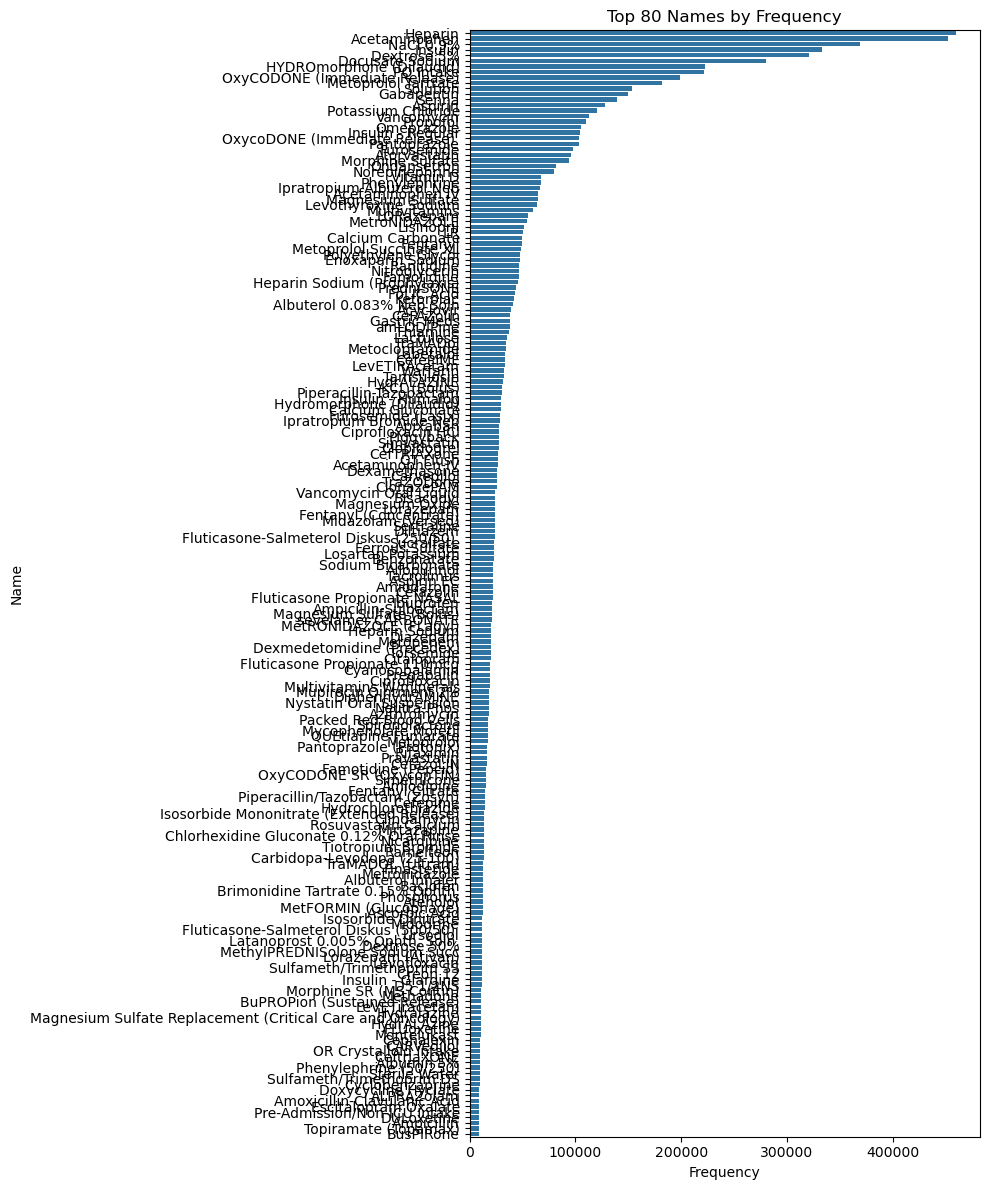

In [49]:
top80_names = combined_tx_df['name'] \
    .value_counts() \
    .nlargest(200)

# 2) Plot horizontally
plt.figure(figsize=(10, 12))
sns.barplot(
    x=top80_names.values,
    y=top80_names.index,
    orient='h'
)
plt.xlabel('Frequency')
plt.ylabel('Name')
plt.title('Top 80 Names by Frequency')
plt.tight_layout()
plt.show()

In [50]:
top_names_tx = combined_tx_df['name'].value_counts().head(80).index
filtered_combined_tx_df = combined_tx_df[combined_tx_df['name'].isin(top_names_tx)]
filtered_combined_tx_df['charttime'] = pd.to_datetime(filtered_combined_tx_df['charttime'])
final_TX_df = filtered_combined_tx_df.sort_values(by=['hadm_id', 'charttime']).reset_index(drop=True)

/var/folders/53/d8br5nln6vq67q925j2wx6kc0000gn/T/ipykernel_3865/2421231807.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_combined_tx_df['charttime'] = pd.to_datetime(filtered_combined_tx_df['charttime'])


In [51]:
final_TX_df

,hadm_id,itemid,charttime,name,value,endtime,amountuom,patientweight,category
0,20000147.0,220949,2121-08-30 22:10:00,Dextrose 5%,1.646542,2121-08-30 22:16:00,mL,94.0,Fluids/Intake
1,20000147.0,221749,2121-08-30 22:10:00,Phenylephrine,0.39517,2121-08-30 22:16:00,mg,94.0,Medications
2,20000147.0,222168,2121-08-30 22:10:00,Propofol,22.641509,2121-08-30 22:16:00,mg,94.0,Medications
3,20000147.0,225943,2121-08-30 22:10:00,Solution,2.264151,2121-08-30 22:16:00,mL,94.0,Fluids/Intake
4,20000147.0,223258,2121-08-30 22:10:00,Insulin - Regular,1.8,2121-08-30 22:46:00,units,94.0,Medications
...,...,...,...,...,...,...,...,...,...
7033247,29999828.0,223258,2180-10-29 08:13:00,Insulin - Regular,2.0,2180-10-29 08:14:00,units,164.0,Medications
7033248,29999828.0,225828,2180-10-29 10:09:00,LR,795.833303,2180-10-29 16:31:00,mL,164.0,Fluids/Intake
7033249,29999828.0,223258,2180-10-29 12:13:00,Insulin - Regular,4.0,2180-10-29 12:14:00,units,164.0,Medications
7033250,29999828.0,225975,2180-10-29 14:22:00,Heparin Sodium (Prophylaxis),1.0,2180-10-29 14:23:00,dose,164.0,Medications


In [13]:

#------------------------------------------------------------------------------
# Merge chartevents and labevents with their respective dictionary DataFrames 
# to add a column for the item name.
# For chartevents, merge with d_chartitems_df on 'itemid'.
chartevents_filtered = pd.merge(
    chartevents_filtered,
    d_chartitems_df[['itemid', 'label', 'category']],
    on='itemid',
    how='left'
)
# Rename the added 'label' column (if desired) to something like 'item_name'
chartevents_filtered.rename(columns={'label': 'name'}, inplace=True)
chartevents_filtered = chartevents_filtered[chartevents_filtered['category'].isin(['Routine Vital Signs', 'Respiratory', 'Labs', 'Neurological', 'Hemodynamics' ])]

# For labevents, merge with d_labitems_df on 'itemid'.
labevents_filtered = pd.merge(
    labevents_filtered,
    d_labitems_df[['itemid', 'label', 'category']],
    on='itemid',
    how='left'
)
labevents_filtered.rename(columns={'label': 'name'}, inplace=True)


outputevents_filtered.head()

outputevents_filtered = pd.merge(
    outputevents_filtered,
    d_chartitems_df[['itemid', 'label', 'category']],
    on='itemid',
    how='left'
)
outputevents_filtered.rename(columns={'label': 'name'}, inplace=True)
outputevents_filtered.head()


micro_events_filtered['value_text'] = micro_events_filtered['value']
micro_events_filtered['value'] = ~micro_events_filtered['value_text'].str.contains('no', case=False, na=False)
micro_events_filtered['value'] = micro_events_filtered['value'].astype(int)





In [16]:
import os
import json
import pickle
import pandas as pd

def get_align_labs_prompt(chartname_list, labname_big_list):
    prompt = f'''
    Your task is to map a set of new lab names (provided in list A) to their best matching names from a reference list (provided in list B), 
    which comes with associated itemids. For each new lab name, select the best match from the reference list.

    IMPORTANT:
    - Return only a valid JSON object without any additional text or markdown formatting.
    - Do NOT include triple backticks or any markdown markers.

    Output format:
    {{"new_name": "reference_name", "new_name2": "reference_name2", ...}}

    A) New lab names: 
    {chartname_list}

    B) Reference list: 
    {labname_big_list}
    '''
    return prompt

alignment_path = "../temp_dfs/alignment.pkl"

if os.path.exists(alignment_path):
    print("Loading alignment from pickle...")
    with open(alignment_path, "rb") as f:
        matched_results = pickle.load(f)
    reference_name_to_itemid = labevents_filtered.drop_duplicates(subset='name').set_index('name')['itemid'].to_dict()
else:
    print("Computing alignment...")
    chart_name_chunk_size = 10

    # Extract new lab names
    new_names = list(chartevents_filtered[chartevents_filtered['category'] == 'Labs']['name'].unique())

    # Extract reference lab names
    reference_name_to_itemid = labevents_filtered.drop_duplicates(subset='name').set_index('name')['itemid'].to_dict()

    system_prompt = (
        "You are a helpful matching assistant. Map each new lab name to the best matching reference name from the list provided. "
        "Return only valid JSON (no markdown, no triple backticks)."
    )

    iterations = 3
    matched_results = {}

    for i in range(0, len(new_names), chart_name_chunk_size):
        chunk = new_names[i:i + chart_name_chunk_size]
        input_prompt = get_align_labs_prompt(chunk, list(reference_name_to_itemid.keys()))
        
        # Retrieve responses from the LLM
        raw_results = run_LLM(system_prompt, input_prompt, iterations, model="gpt-4o")
        raw_results_json = json.loads(raw_results)
        print("raw_results_json", raw_results_json)
        matched_results.update(raw_results_json)

    # Save result to pickle
    os.makedirs(os.path.dirname(alignment_path), exist_ok=True)
    with open(alignment_path, "wb") as f:
        pickle.dump(matched_results, f)

Loading alignment from pickle...


In [17]:
# Create a boolean mask for rows in the "Labs" category
labs_mask = chartevents_filtered['category'] == 'Labs'

# For the rows where category is "Labs", create a copy to work with
labs_df = chartevents_filtered.loc[labs_mask].copy()

# Map the current 'name' values to the matched reference names (if available)
labs_df['ref_name'] = labs_df['name'].map(matched_results)

# Replace the original name with the reference name where available.
# If no mapping is found, keep the original name.
labs_df['name'] = labs_df['ref_name'].combine_first(labs_df['name'])

# Now, update the itemid: if a reference name was found, map it to the new itemid using reference_name_to_itemid.
# Otherwise, keep the original itemid.
labs_df['itemid'] = labs_df['ref_name'].map(reference_name_to_itemid).combine_first(labs_df['itemid'])

# Update the original DataFrame with the new values for the 'Labs' rows
chartevents_filtered.loc[labs_mask, ['name', 'itemid']] = labs_df[['name', 'itemid']]

#print(chartevents_filtered.loc[labs_mask, ['name', 'itemid']].head(20))

In [18]:
combined_physio_df = pd.concat([chartevents_filtered, labevents_filtered, outputevents_filtered, micro_events_filtered], ignore_index=True)[chartevents_filtered.columns]

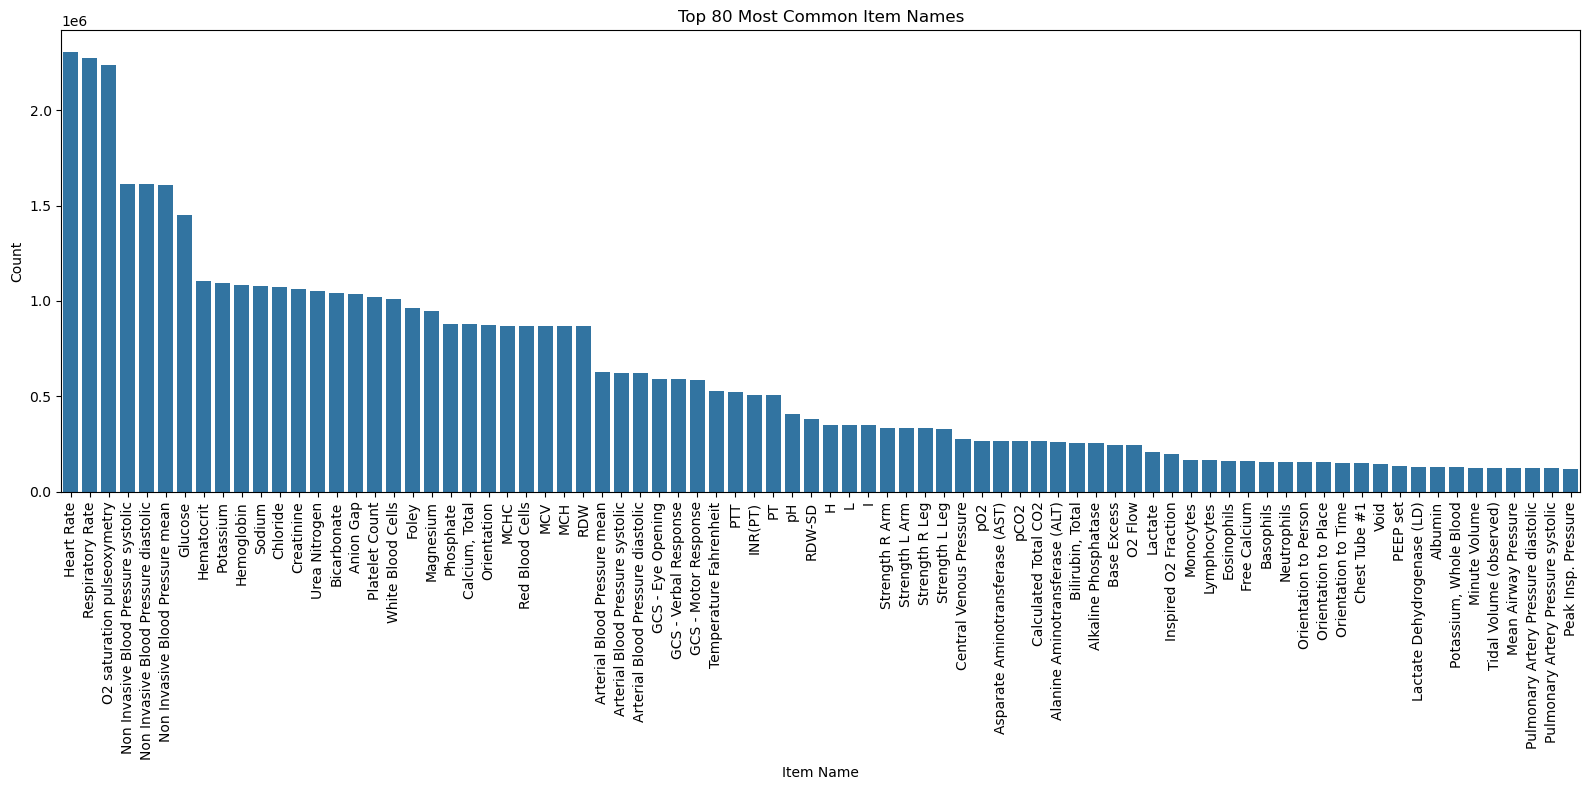

In [29]:
# Get value counts
name_counts = combined_physio_df['name'].value_counts().head(80)

name2item = (
    combined_physio_df
    .drop_duplicates(subset=['name'])          # keep the first occurrence of each name
    [['name','itemid']]
)

name_df = (
    name_counts
    .rename('count')
    .reset_index()
    .rename(columns={'index': 'name'})
    .merge(name2item, on='name', how='left')
)


# Optional: re-order columns
name_df = name_df[['itemid', 'name', 'count']]

plt.figure(figsize=(16, 8))
sns.barplot(data=name_df, x='name', y='count', order=name_df['name'])

plt.xticks(rotation=90)
plt.xlabel('Item Name')
plt.ylabel('Count')
plt.title(f'Top {len(name_df)} Most Common Item Names')
plt.tight_layout()
plt.show()

In [30]:
name_counts

name
Heart Rate                               2303130
Respiratory Rate                         2271365
O2 saturation pulseoxymetry              2237951
Non Invasive Blood Pressure systolic     1611247
Non Invasive Blood Pressure diastolic    1610891
                                          ...   
Tidal Volume (observed)                   122846
Mean Airway Pressure                      122575
Pulmonary Artery Pressure diastolic       121831
Pulmonary Artery Pressure systolic        121802
Peak Insp. Pressure                       120287
Name: count, Length: 80, dtype: int64

In [31]:
name_df

,itemid,name,count
0,220045,Heart Rate,2303130
1,220210,Respiratory Rate,2271365
2,220277,O2 saturation pulseoxymetry,2237951
3,220179,Non Invasive Blood Pressure systolic,1611247
4,220180,Non Invasive Blood Pressure diastolic,1610891
...,...,...,...
75,224685,Tidal Volume (observed),122846
76,224697,Mean Airway Pressure,122575
77,220060,Pulmonary Artery Pressure diastolic,121831
78,220059,Pulmonary Artery Pressure systolic,121802


In [20]:
top_names = combined_physio_df['name'].value_counts().head(80).index
filtered_combined_df = combined_physio_df[combined_physio_df['name'].isin(top_names)]
filtered_combined_df['charttime'] = pd.to_datetime(filtered_combined_df['charttime'])
sorted_filtered_df = filtered_combined_df.sort_values(by=['hadm_id', 'charttime']).reset_index(drop=True)

/var/folders/53/d8br5nln6vq67q925j2wx6kc0000gn/T/ipykernel_3865/1327715329.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_combined_df['charttime'] = pd.to_datetime(filtered_combined_df['charttime'])


In [21]:
def normalize_value(df, value_col='value', group_col='itemid'):
    """
    Normalizes the values for each itemid in the DataFrame based on their own mean and std.
    Any standardized values greater than 3 or less than -3 (i.e. outliers) are clipped to ±3.

    Parameters:
        df (pd.DataFrame): The input DataFrame containing the lab data.
        value_col (str): The name of the column containing the values to normalize.
        group_col (str): The column name by which to group the data (each unique itemid).

    Returns:
        pd.DataFrame: A new DataFrame with the normalized and clipped values.
    """
    # Compute the mean and std for each group (each itemid)
    means = df.groupby(group_col)[value_col].transform('mean')
    stds = df.groupby(group_col)[value_col].transform('std')
    
    # Standardize the values: (value - mean) / std
    normalized = (df[value_col] - means) / stds
    
    # Clip the standardized values to the range [-3, 3]
    normalized_clipped = normalized.clip(lower=-3, upper=3)
    
    # Create a copy of the DataFrame with the normalized values
    df_normalized = df.copy()
    df_normalized[value_col] = normalized_clipped
    
    return df_normalized


In [22]:
sorted_filtered_normalised_df = normalize_value(sorted_filtered_df, 'value', 'name')


In [133]:
sorted_filtered_normalised_df.to_pickle('../temp_dfs/sorted_filtered_df.pkl')

In [23]:
filtered_ds = merged_with_disch_df['hadm_id'].isin(sorted_filtered_df['hadm_id'])
merged_with_disch_df_final_filtered = merged_with_disch_df.loc[filtered_ds]
#merged_with_disch_df_final_filtered.to_pickle('../temp_dfs/merged_with_disch_df_final_filtered.pkl')


In [35]:
import pickle
with open('../temp_dfs_lite/var_names.pkl', 'wb') as f:
    pickle.dump(list(name_df['name']), f)

with open('../temp_dfs_lite/itemid_list.pkl', 'wb') as f:
    pickle.dump(list(name_df['itemid']), f)

In [33]:
list(name_df['name'])

['Heart Rate',
 'Respiratory Rate',
 'O2 saturation pulseoxymetry',
 'Non Invasive Blood Pressure systolic',
 'Non Invasive Blood Pressure diastolic',
 'Non Invasive Blood Pressure mean',
 'Glucose',
 'Hematocrit',
 'Potassium',
 'Hemoglobin',
 'Sodium',
 'Chloride',
 'Creatinine',
 'Urea Nitrogen',
 'Bicarbonate',
 'Anion Gap',
 'Platelet Count',
 'White Blood Cells',
 'Foley',
 'Magnesium',
 'Phosphate',
 'Calcium, Total',
 'Orientation',
 'MCHC',
 'Red Blood Cells',
 'MCV',
 'MCH',
 'RDW',
 'Arterial Blood Pressure mean',
 'Arterial Blood Pressure systolic',
 'Arterial Blood Pressure diastolic',
 'GCS - Eye Opening',
 'GCS - Verbal Response',
 'GCS - Motor Response',
 'Temperature Fahrenheit',
 'PTT',
 'INR(PT)',
 'PT',
 'pH',
 'RDW-SD',
 'H',
 'L',
 'I',
 'Strength R Arm',
 'Strength L Arm',
 'Strength R Leg',
 'Strength L Leg',
 'Central Venous Pressure',
 'pO2',
 'Asparate Aminotransferase (AST)',
 'pCO2',
 'Calculated Total CO2',
 'Alanine Aminotransferase (ALT)',
 'Bilirubin, T

In [182]:
filtered_ds = discharge_df['hadm_id'].isin(sorted_filtered_df['hadm_id'])
discharge_df = discharge_df.loc[filtered_ds]
discharge_df.to_pickle('../temp_dfs/discharge_df_filtered.pkl')

In [122]:
sorted_filtered_df['rounded_charttime'] = sorted_filtered_df['charttime'].dt.round('3h')


In [123]:
sorted_filtered_df.head()

,hadm_id,charttime,itemid,value,name,category,rounded_charttime
0,20000019.0,2159-03-21 06:45:00,50868,14.0,Anion Gap,Chemistry,2159-03-21 06:00:00
1,20000019.0,2159-03-21 06:45:00,50882,24.0,Bicarbonate,Chemistry,2159-03-21 06:00:00
2,20000019.0,2159-03-21 06:45:00,50902,103.0,Chloride,Chemistry,2159-03-21 06:00:00
3,20000019.0,2159-03-21 06:45:00,50912,1.1,Creatinine,Chemistry,2159-03-21 06:00:00
4,20000019.0,2159-03-21 06:45:00,50931,169.0,Glucose,Chemistry,2159-03-21 06:00:00


In [138]:
import torch
hadm_id = 20000019.0
joint_cache_dir = "/Users/riccardoconci/Local_documents/!!GeomML_2025/GeomMLProj/temp_dfs/processed_tensors"
full_cache_key = lambda hadm: f"tensor_cache_{hadm}.pt"
full_cache_path = os.path.join(joint_cache_dir, full_cache_key(hadm_id))
full_data = torch.load(full_cache_path)

In [139]:
full_data

{'values_tensor': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 'mask_tensor': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 'abs_time_tensor': tensor([ 6., 30., 54., 60.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  

In [141]:
hadm_lengths = pickle.load(open('../temp_dfs/hadm_lengths.pkl', 'rb'))


In [156]:
merged_with_disch_df_final_filtered.columns

Index(['subject_id', 'hadm_id', 'admittime', 'dischtime', 'deathtime',
       'admission_type', 'admit_provider_id', 'admission_location',
       'discharge_location', 'insurance', 'language', 'marital_status', 'race',
       'edregtime', 'edouttime', 'hospital_expire_flag', 'gender',
       'anchor_age', 'anchor_year', 'anchor_year_group', 'dod', 'age',
       'transfer_id', 'eventtype', 'careunit', 'intime', 'outtime',
       'admit_duration', 'death_timestamp', 'days_disch_to_death',
       'hours_admission_to_death', 'days_admission_to_death'],
      dtype='object')

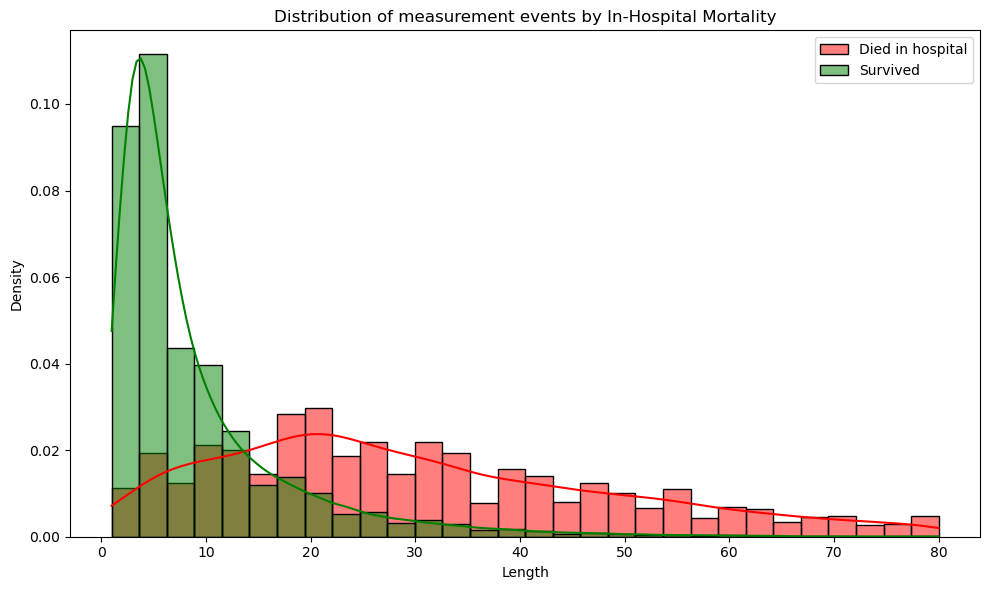

In [155]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Split hadm_ids into two groups
expired_ids = set(merged_with_disch_df_final_filtered[merged_with_disch_df_final_filtered['hospital_expire_flag'] == 1]['hadm_id'])
survived_ids = set(merged_with_disch_df_final_filtered[merged_with_disch_df_final_filtered['hospital_expire_flag'] == 0]['hadm_id'])

# Extract lengths for each group
expired_lengths = [hadm_lengths[hid] for hid in expired_ids if hid in hadm_lengths]
survived_lengths = [hadm_lengths[hid] for hid in survived_ids if hid in hadm_lengths]

# Plot both distributions
plt.figure(figsize=(10, 6))
sns.histplot(expired_lengths, color='red', label='Died in hospital', kde=True, stat="density", bins=30)
sns.histplot(survived_lengths, color='green', label='Survived', kde=True, stat="density", bins=30)
plt.xlabel("Length")
plt.ylabel("Density")
plt.title("Distribution of measurement events by In-Hospital Mortality")
plt.legend()
plt.tight_layout()
plt.show()

In [177]:
import pandas as pd

def preprocess_baseline_values(df, 
                               id_col='hadm_id',
                               categorical_features=None, 
                               continuous_features=None, 
                               binary_features=None,
                               drop_first=True):
    """
    Preprocess baseline values for deep learning input while preserving a unique identifier.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input DataFrame containing baseline values including an identifier column.
        
    id_col : str, default 'hadm_id'
        Name of the identifier column, which will be set as the DataFrame index.
        
    categorical_features : list of str, optional
        List of columns to one-hot encode (e.g., 'gender', 'race', etc.).
        
    continuous_features : list of str, optional
        List of columns to be treated as continuous numeric features (e.g., 'admit_duration').
        
    binary_features : list of str, optional
        List of columns that are already binary. Their values will be converted to 0 or 1.
        
    drop_first : bool, default True
        Whether to drop the first level in one-hot encoding to avoid collinearity.
    
    Returns:
    --------
    processed_df : pandas.DataFrame
        A DataFrame with the identifier set as the index, where categorical features have been
        one-hot encoded (with values 0 or 1), continuous features converted to numeric, and binary
        features converted to 0 or 1.
    """
    # Create a copy of the input dataframe and set the identifier as the index.
    processed_df = df.copy()
    processed_df.set_index(id_col, inplace=True)
    
    # Process categorical features with one-hot encoding and ensure 0/1 integer values.
    if categorical_features is not None:
        dummies = pd.get_dummies(processed_df[categorical_features], drop_first=drop_first).astype(int)
    else:
        dummies = pd.DataFrame(index=processed_df.index)
    
    # Process continuous features ensuring they are numeric.
    if continuous_features is not None:
        continuous = processed_df[continuous_features].astype(float)/100
    else:
        continuous = pd.DataFrame(index=processed_df.index)
        
    # Process binary features and convert them to integer 0 or 1.
    if binary_features is not None:
        binary = processed_df[binary_features].apply(pd.to_numeric, errors='coerce').fillna(0).astype(int)
    else:
        binary = pd.DataFrame(index=processed_df.index)
    
    # Combine the processed parts into one DataFrame.
    final_df = pd.concat([continuous, binary, dummies], axis=1)
    
    return final_df

# Example usage:
# Your DataFrame 'merged_with_disch_df_final_filtered' should include:
#  - A unique identifier column 'hadm_id'
#  - Continuous feature: 'admit_duration'
#  - Categorical features: 'gender', 'race', 'marital_status', 'insurance', 
#                        'language', 'admission_location', 'admission_type'
#  - (Optionally) any additional binary features.
categorical_features = ['gender', 'race', 'marital_status', 
                        'insurance', 'language', 'admission_location', 'admission_type']
continuous_features = ['age']
binary_features = []  # Fill in with any binary feature columns, if available.

processed_baseline_df = preprocess_baseline_values(
    merged_with_disch_df_final_filtered, 
    id_col='hadm_id',
    categorical_features=categorical_features, 
    continuous_features=continuous_features, 
    binary_features=binary_features, 
    drop_first=True
)

print("Processed DataFrame shape:", processed_baseline_df.shape)
print("Index name:", processed_baseline_df.index.name)

Processed DataFrame shape: (736249, 83)
Index name: hadm_id


In [181]:
processed_baseline_df.to_pickle('../temp_dfs/processed_baseline_df.pkl')

In [183]:
hadm_id

20000019.0

In [14]:
import os
import json
import pickle
import pandas as pd

def get_physio_category_prompt(physio_names_chunk, previous_categories=None):
    prompt = f'''
Looking at the following list of lab items, provide a category for each lab item. This is a single word based on organ function or basic physiology.
For example: renal (electrolytes, etc), inflammatory (WBC, CRP, etc), clotting (platelets, PT, INR, etc), haematologic (RBCs, etc), endocrine, cardiovascular, hepatobiliary, respiratory , metabolic etc.
Don't use 'general' as a category.

Return only a valid JSON object without any additional text or markdown formatting.
- Do NOT include triple backticks or any markdown markers.

Names:
{physio_names_chunk}

Previous categories:
{previous_categories}

Output format:
{{"name1": "category1", "name2": "category2", ...}}
'''
    return prompt

def get_physio_categories(chartevents_filtered, labevents_filtered, run_LLM,
                          chart_name_chunk_size=30,
                          system_prompt="You are a helpful matching assistant.",
                          iterations=3,
                          pickle_filename="temp_dfs/physio_categories.pkl"):
    """
    Generate category mappings for lab item names using LLM and save/load results as a pickle file.

    Parameters:
      - chartevents_filtered: pandas DataFrame that contains a 'name' column.
      - labevents_filtered: pandas DataFrame that contains a 'name' column.
      - run_LLM: a function that takes system_prompt, input_prompt, iterations, and model parameters,
                 returns a string response from the LLM.
      - chart_name_chunk_size (int): number of lab names per LLM call.
      - system_prompt (str): system prompt for the LLM.
      - iterations (int): number of iterations per LLM call.
      - pickle_filename (str): path to the pickle file for caching results.

    Returns:
      - category_matched_results (dict): mapping from lab item names to assigned categories.
    """

    # Ensure the temp_dfs directory exists.
    temp_dir = os.path.dirname(pickle_filename)
    if not os.path.exists(temp_dir):
        os.makedirs(temp_dir)
        print(f"Created directory: {temp_dir}")
    
    # If the pickle file already exists, load and return the cached results.
    if os.path.exists(pickle_filename):
        with open(pickle_filename, "rb") as f:
            category_matched_results = pickle.load(f)
        print("Loaded cached category mapping from", pickle_filename)
        return category_matched_results

    # Combine lab item names from both datasets.
    all_physio_names = pd.concat([
        chartevents_filtered['name'], 
        labevents_filtered['name']
    ])
    all_physio_names = list(all_physio_names.unique())
    print("Total unique lab items:", len(all_physio_names))

    category_matched_results = {}

    # Process lab names in chunks.
    for i in range(0, len(all_physio_names), chart_name_chunk_size):
        # Create a chunk list.
        chunk = all_physio_names[i:i + chart_name_chunk_size]
        
        # Extract the set of unique categories used so far.
        previous_categories = sorted(list(set(category_matched_results.values())))
        
        # Build prompt with current chunk and the previously used categories.
        input_prompt = get_physio_category_prompt(chunk, previous_categories=previous_categories)
        
        # Retrieve responses from the LLM.
        raw_results = run_LLM(system_prompt, input_prompt, iterations, model="gpt-4o")
        
        try:
            raw_results_json = json.loads(raw_results)
            print(f"Response for chunk starting at index {i} ->", raw_results_json)
        except Exception as e:
            print(f"Error parsing JSON response for chunk starting at index {i}: {e}")
            continue

        # Update results with new assignments.
        category_matched_results.update(raw_results_json)

    # Save the results to pickle.
    with open(pickle_filename, "wb") as f:
        pickle.dump(category_matched_results, f)
    print("Saved category mapping to", pickle_filename)

    return category_matched_results


In [15]:
category_matched_results = get_physio_categories(chartevents_filtered, labevents_filtered, run_LLM)
# Convert the dictionary to a DataFrame
categories_df = pd.DataFrame(
    list(category_matched_results.items()),
    columns=['name', 'physio_category']
)

# Count how many items are in each physio category
categories_df['physio_category'].value_counts()


Loaded cached category mapping from temp_dfs/physio_categories.pkl


physio_category
respiratory       100
haematologic       75
renal              71
cardiovascular     70
metabolic          62
other              60
immunological      60
neurological       35
clotting           35
inflammatory       31
hepatobiliary      27
endocrine          27
Name: count, dtype: int64

In [16]:
categories_df[categories_df['physio_category']=='respiratory']['name'][:30]

5                   Respiratory Rate
6        O2 saturation pulseoxymetry
7                            O2 Flow
30      O2 Flow (additional cannula)
31                          PEEP set
32                   Ventilator Type
33           Tidal Volume (observed)
34        Tidal Volume (spontaneous)
35                     Minute Volume
36    Respiratory Rate (spontaneous)
37          Respiratory Rate (Total)
38               Peak Insp. Pressure
39              Mean Airway Pressure
40                         PSV Level
41                  Inspiratory Time
42                   Ventilator Mode
43                          Paw High
44                          Vti High
45                    Apnea Interval
46              Inspired O2 Fraction
64                    CO2 production
65                         Fspn High
66                Tidal Volume (set)
67            Respiratory Rate (Set)
68                 Flow Rate (L/min)
69                  Plateau Pressure
70        Ventilator Mode (Hamilton)
7

In [25]:
list(categories_df['name'].unique())

['Temperature Fahrenheit',
 'Non Invasive Blood Pressure systolic',
 'Non Invasive Blood Pressure diastolic',
 'Non Invasive Blood Pressure mean',
 'Heart Rate',
 'Respiratory Rate',
 'O2 saturation pulseoxymetry',
 'O2 Flow',
 'GCS - Eye Opening',
 'GCS - Motor Response',
 'Orientation to Person',
 'Orientation to Place',
 'Orientation to Time',
 'Strength L Arm',
 'Strength L Leg',
 'Strength R Leg',
 'Strength R Arm',
 'GCS - Verbal Response',
 'Potassium, Whole Blood',
 'Chloride',
 'Creatinine',
 'Glucose',
 'Magnesium',
 'Sodium',
 'Urea Nitrogen',
 'Calcium, Total',
 'Phosphate',
 'Anion Gap',
 'Potassium',
 'Bicarbonate',
 'O2 Flow (additional cannula)',
 'PEEP set',
 'Ventilator Type',
 'Tidal Volume (observed)',
 'Tidal Volume (spontaneous)',
 'Minute Volume',
 'Respiratory Rate (spontaneous)',
 'Respiratory Rate (Total)',
 'Peak Insp. Pressure',
 'Mean Airway Pressure',
 'PSV Level',
 'Inspiratory Time',
 'Ventilator Mode',
 'Paw High',
 'Vti High',
 'Apnea Interval',
 'Insp

In [17]:
chartevents_filtered['physio_category'] = chartevents_filtered['name'].map(category_matched_results)
labevents_filtered['physio_category'] = labevents_filtered['name'].map(category_matched_results)

labevents_filtered = labevents_filtered[labevents_filtered['physio_category'] != 'other']
chartevents_filtered = chartevents_filtered[chartevents_filtered['physio_category'] != 'other']
categories_df = categories_df[categories_df['physio_category']!='other']

In [18]:
labevents_filtered.head()

,hadm_id,itemid,charttime,value,name,category,physio_category
0,22595853.0,51491,2180-05-07 00:10:00,6.000,pH,Hematology,respiratory
1,22595853.0,51492,2180-05-07 00:10:00,30.000,Protein,Hematology,metabolic
2,22595853.0,51498,2180-05-07 00:10:00,1.033,Specific Gravity,Hematology,renal
3,22595853.0,51514,2180-05-07 00:10:00,4.000,Urobilinogen,Hematology,hepatobiliary
4,22595853.0,51221,2180-05-07 05:05:00,37.600,Hematocrit,Hematology,haematologic


In [19]:
#physio events
chartevents_filtered = chartevents_filtered.set_index('hadm_id')
labevents_filtered = labevents_filtered.set_index('hadm_id')
outputevents_filtered = outputevents_filtered.set_index('hadm_id')
ed_vitals_long_df = ed_vitals_long_df.set_index('hadm_id')
micro_events_filtered = micro_events_filtered.set_index('hadm_id')


#treatment events
inputevents_filtered = inputevents_filtered.set_index('hadm_id')
emar_filtered = emar_filtered.set_index('hadm_id')
ed_pyxis_merged_df = ed_pyxis_merged_df.set_index('hadm_id')


#baseline events
ed_medrecon_merged_df = ed_medrecon_merged_df.set_index('hadm_id')

#ds
discharge_df.rename(columns={'text': 'value'}, inplace=True)
discharge_df = discharge_df.set_index('hadm_id')


In [20]:
def normalize_itemid(df, value_col='value', group_col='itemid'):
    """
    Normalizes the values for each itemid in the DataFrame based on their own mean and std.
    Any standardized values greater than 3 or less than -3 (i.e. outliers) are clipped to ±3.

    Parameters:
        df (pd.DataFrame): The input DataFrame containing the lab data.
        value_col (str): The name of the column containing the values to normalize.
        group_col (str): The column name by which to group the data (each unique itemid).

    Returns:
        pd.DataFrame: A new DataFrame with the normalized and clipped values.
    """
    # Compute the mean and std for each group (each itemid)
    means = df.groupby(group_col)[value_col].transform('mean')
    stds = df.groupby(group_col)[value_col].transform('std')
    
    # Standardize the values: (value - mean) / std
    normalized = (df[value_col] - means) / stds
    
    # Clip the standardized values to the range [-3, 3]
    normalized_clipped = normalized.clip(lower=-3, upper=3)
    
    # Create a copy of the DataFrame with the normalized values
    df_normalized = df.copy()
    df_normalized[value_col] = normalized_clipped
    
    return df_normalized


In [41]:
labevents_filtered = normalize_itemid(labevents_filtered)
chartevents_filtered = normalize_itemid(chartevents_filtered)   


In [42]:
import torch

def process_baseline(hadm_id):
    """
    Extracts the age and gender from the merged_with_disch_df for the given hadm_id.
    Gender is mapped as binary: 0 for Male (or 'M'/'Male') and 1 for Female (or 'F'/'Female').
    Returns a tensor of shape [2] in the form [age, gender].
    """
   
    meta = merged_with_disch_df[
        merged_with_disch_df['hadm_id'] == hadm_id
    ]
    if meta.empty:
        # If not found, return default values (could also choose to raise an error).
        age_value = 0.0
        gender_value = -1
    else:
        row = meta.iloc[0]
        try:
            age_value = float(row['age'])
        except Exception:
            age_value = 0.0

        # Map gender: use 'M' or 'Male' as male (0), and 'F' or 'Female' as female (1).
        gender_raw = str(row['gender']).strip()
        gender_mapping = {'M': 0, 'Male': 0, 'F': 1, 'Female': 1}
        gender_value = gender_mapping.get(gender_raw, -1)

    # Create and return the tensor.
    baseline_tensor = torch.tensor([age_value, gender_value], dtype=torch.float)
    return baseline_tensor

In [51]:
def get_events_for_hadm_groups(hadm_id):

    # Process as before:
    def select_if_exists(df):
        if df is not None and hasattr(df, 'index') and hadm_id in df.index:
            return df.loc[[hadm_id]]
        else:
            return None
        
    baseline_tensor = process_baseline(hadm_id)
        
    # Physio events
    physio_sources = []
    physio_sources.append((chartevents_filtered, 'chartevents_filtered'))
    physio_sources.append((labevents_filtered, 'labevents_filtered'))
   
    physio_dfs = []
    for df, source_name in physio_sources:
        tmp = select_if_exists(df)
        if tmp is not None:
            tmp = tmp.copy()
            tmp['source'] = source_name
            physio_dfs.append(tmp)

    if physio_dfs:
        physio_df = pd.concat(physio_dfs, sort=False)
        if 'charttime' in physio_df.columns:
            physio_df['charttime'] = pd.to_datetime(physio_df['charttime'], errors='coerce')
            physio_df = physio_df.sort_values(by='charttime')
    else:
        physio_df = pd.DataFrame()

    # Treatments
    treatment_sources = []
    treatment_sources.append((inputevents_filtered, 'inputevents_filtered'))
    treatment_sources.append((emar_filtered, 'emar_filtered'))
 
        
    treatment_dfs = []
    for df, source_name in treatment_sources:
        tmp = select_if_exists(df)
        if tmp is not None:
            tmp = tmp.copy()
            tmp['source'] = source_name
            treatment_dfs.append(tmp)

    if treatment_dfs:
        treatments_df = pd.concat(treatment_dfs, sort=False)
        if 'charttime' in treatments_df.columns:
            treatments_df['charttime'] = pd.to_datetime(treatments_df['charttime'], errors='coerce')
            treatments_df = treatments_df.sort_values(by='charttime')
    else:
        treatments_df = pd.DataFrame()

    # Compose tuple of event groups
    event_tuple = (baseline_tensor, physio_df, treatments_df)
    # Save to cache for future accesses
    return event_tuple

In [59]:
all_itemids = set()
for df in [chartevents_filtered, labevents_filtered]:
    if 'itemid' in df.columns:
        all_itemids.update(df['itemid'].unique())
itemid_list = sorted(list(all_itemids))

In [61]:
len(itemid_list)

669

<Axes: xlabel='admit_duration', ylabel='Count'>

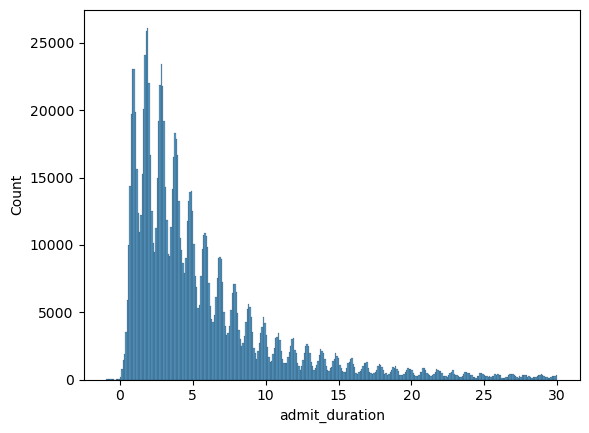

In [63]:
merged_with_disch_df = merged_with_disch_df[merged_with_disch_df['admit_duration'] < 30]

sns.histplot(merged_with_disch_df['admit_duration'])

In [65]:
merged_with_disch_df[merged_with_disch_df['admit_duration'] >29]

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,...,anchor_year_group,dod,age,transfer_id,eventtype,careunit,intime,outtime,admit_duration,days_disch_to_death
824,10003400,23559586,2137-08-04 00:07:00,2137-09-02 17:05:00,2137-09-02 17:05:00,URGENT,P32CSX,TRANSFER FROM HOSPITAL,DIED,Medicare,...,2011 - 2013,2137-09-02,75,30955173.0,transfer,Medical Intensive Care Unit (MICU),2137-08-18 20:54:06,2137-09-02 19:17:11,29.706944,-0.711806
825,10003400,23559586,2137-08-04 00:07:00,2137-09-02 17:05:00,2137-09-02 17:05:00,URGENT,P32CSX,TRANSFER FROM HOSPITAL,DIED,Medicare,...,2011 - 2013,2137-09-02,75,32086145.0,transfer,Medicine,2137-08-13 17:54:54,2137-08-17 17:36:37,29.706944,-0.711806
826,10003400,23559586,2137-08-04 00:07:00,2137-09-02 17:05:00,2137-09-02 17:05:00,URGENT,P32CSX,TRANSFER FROM HOSPITAL,DIED,Medicare,...,2011 - 2013,2137-09-02,75,32361364.0,admit,Medicine,2137-08-05 00:13:22,2137-08-10 16:16:04,29.706944,-0.711806
827,10003400,23559586,2137-08-04 00:07:00,2137-09-02 17:05:00,2137-09-02 17:05:00,URGENT,P32CSX,TRANSFER FROM HOSPITAL,DIED,Medicare,...,2011 - 2013,2137-09-02,75,33775805.0,transfer,PACU,2137-08-10 16:16:04,2137-08-10 19:54:51,29.706944,-0.711806
828,10003400,23559586,2137-08-04 00:07:00,2137-09-02 17:05:00,2137-09-02 17:05:00,URGENT,P32CSX,TRANSFER FROM HOSPITAL,DIED,Medicare,...,2011 - 2013,2137-09-02,75,34577403.0,transfer,Medical/Surgical Intensive Care Unit (MICU/SICU),2137-08-10 19:54:51,2137-08-13 17:54:54,29.706944,-0.711806
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2003970,19997367,20617667,2126-04-20 07:15:00,2126-05-19 14:15:00,NaN,URGENT,P8286C,PHYSICIAN REFERRAL,CHRONIC/LONG TERM ACUTE CARE,Medicare,...,2011 - 2013,NaT,63,33493268.0,transfer,Cardiac Vascular Intensive Care Unit (CVICU),2126-05-04 18:02:18,2126-05-11 18:51:13,29.291667,NaN
2003971,19997367,20617667,2126-04-20 07:15:00,2126-05-19 14:15:00,NaN,URGENT,P8286C,PHYSICIAN REFERRAL,CHRONIC/LONG TERM ACUTE CARE,Medicare,...,2011 - 2013,NaT,63,35474548.0,transfer,Cardiac Vascular Intensive Care Unit (CVICU),2126-05-11 18:51:13,2126-05-12 22:15:23,29.291667,NaN
2003972,19997367,20617667,2126-04-20 07:15:00,2126-05-19 14:15:00,NaN,URGENT,P8286C,PHYSICIAN REFERRAL,CHRONIC/LONG TERM ACUTE CARE,Medicare,...,2011 - 2013,NaT,63,35616526.0,transfer,Cardiac Vascular Intensive Care Unit (CVICU),2126-04-21 10:09:25,2126-04-22 19:09:12,29.291667,NaN
2003973,19997367,20617667,2126-04-20 07:15:00,2126-05-19 14:15:00,NaN,URGENT,P8286C,PHYSICIAN REFERRAL,CHRONIC/LONG TERM ACUTE CARE,Medicare,...,2011 - 2013,NaT,63,38147317.0,admit,Cardiac Surgery,2126-04-20 11:18:11,2126-04-21 08:44:45,29.291667,NaN


In [ ]:
merged_with_disch_df

In [66]:

# Example usage:
example_hadm_id = 23559586  # replace with your desired hadm_id
baseline_tensor, physio_df, treatments_df = get_events_for_hadm_groups(example_hadm_id)


In [29]:
physio_df

NameError: name 'physio_df' is not defined

In [57]:
def pivot_and_pad_physio(physio_df, itemid_list, T):
    """
    Given a patient's physio_df (with columns ['charttime', 'itemid', 'value', ...]),
    produce three outputs:
    1. A tensor of physiologic values of shape (T, NUM_ITEMIDS)
    2. A tensor of binary masks of shape (T, NUM_ITEMIDS) (1 if present, 0 if missing)
    3. A tensor of time offsets (in hours) from the earliest event, of shape (T,)
    Also compute 'length', the number of time steps with any data (i.e. where mask has any 1s).
    
    Steps:
    1. Round charttime to 6h increments.
    2. Compute the time offset for each rounded charttime relative to the first event.
    3. Pivot itemid -> columns (one column per itemid) using the first value observed.
    4. Create a mask indicating where data was observed.
    5. Pad or truncate the values, mask, and time offset arrays to exactly T time steps.
    6. Convert the arrays into PyTorch tensors.
    7. Compute the number of time steps that contain any data.
    """
    if physio_df.empty:
        num_items = len(itemid_list)
        values_array = np.zeros((T, num_items), dtype=np.float32)
        mask_array = np.zeros((T, num_items), dtype=np.float32)
        time_offsets_array = np.zeros((T,), dtype=np.float32)
        length = T  # Since it's all padding, you might opt for 0 instead.
        return (torch.from_numpy(values_array).float(),
                torch.from_numpy(mask_array).float(),
                torch.from_numpy(time_offsets_array).float(),
                length)

    # 1) Round charttime to 6H increments.
    physio_df = physio_df.copy()
    physio_df['charttime'] = pd.to_datetime(physio_df['charttime'], errors='coerce')
    physio_df['rounded_charttime'] = physio_df['charttime'].dt.round('6H')

    # 2) Compute time offsets in hours relative to the earliest rounded_charttime.
    times = np.sort(physio_df['rounded_charttime'].unique())
    if len(times) == 0:
        time_offsets_initial = np.array([], dtype=np.float32)
    else:
        base_time = times[0]
        time_offsets_initial = np.array([(t - base_time) / pd.Timedelta(hours=1) for t in times], dtype=np.float32)

    # 3) Pivot the dataframe so that each row corresponds to a rounded_charttime and each column to an itemid.
    pivot_df = physio_df.pivot_table(
        index='rounded_charttime',
        columns='itemid',
        values='value',
        aggfunc='first'
    )
    # Ensure that all desired itemids are included in the correct order.
    pivot_df = pivot_df.sort_index().reindex(columns=itemid_list)
    
    # 4) Create separate dataframes for values and binary mask.
    values_full = pivot_df.fillna(0)
    mask_full = pivot_df.notnull().astype(int)
    
    # 5) Determine the number of available time steps and re-calculate time offsets using the pivot index.
    num_times = values_full.shape[0]
    if num_times > 0:
        pivot_times = values_full.index.to_series().reset_index(drop=True)
        base_time = pivot_times[0]
        time_offsets = ((pivot_times - base_time) / pd.Timedelta(hours=1)).to_numpy(dtype=np.float32)
    else:
        time_offsets = np.array([], dtype=np.float32)
        
    # Pad or truncate the arrays if needed to ensure exactly T time steps.
    if num_times < T:
        pad_rows = T - num_times
        pad_values = pd.DataFrame(np.zeros((pad_rows, values_full.shape[1])), columns=values_full.columns)
        pad_mask = pd.DataFrame(np.zeros((pad_rows, mask_full.shape[1])), columns=mask_full.columns)
        values_full = pd.concat([values_full, pad_values], ignore_index=True)
        mask_full = pd.concat([mask_full, pad_mask], ignore_index=True)
        time_offsets = np.concatenate([time_offsets, np.zeros(pad_rows, dtype=np.float32)])
    else:
        values_full = values_full.iloc[:T]
        mask_full = mask_full.iloc[:T]
        time_offsets = time_offsets[:T]

    # 7) Compute the length: count time steps that have any valid data (mask sum > 0).
    has_data = mask_full.sum(axis=1) > 0
    length = int(np.sum(has_data))
    if length == 0:  # Edge case: if no data, ensure nonzero length.
        length = 1

    # Convert the individual arrays to PyTorch tensors.
    values_tensor = torch.from_numpy(values_full.to_numpy(dtype=np.float32)).float()
    mask_tensor = torch.from_numpy(mask_full.to_numpy(dtype=np.float32)).float()
    time_offsets_tensor = torch.from_numpy(time_offsets).float()

    return values_tensor, mask_tensor, time_offsets_tensor, length

In [75]:
T=96
values_tensor, mask_tensor, time_offsets_tensor, length = pivot_and_pad_physio(physio_df, itemid_list, T)

/var/folders/53/d8br5nln6vq67q925j2wx6kc0000gn/T/ipykernel_26700/955744466.py:33: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  physio_df['rounded_charttime'] = physio_df['charttime'].dt.round('6H')


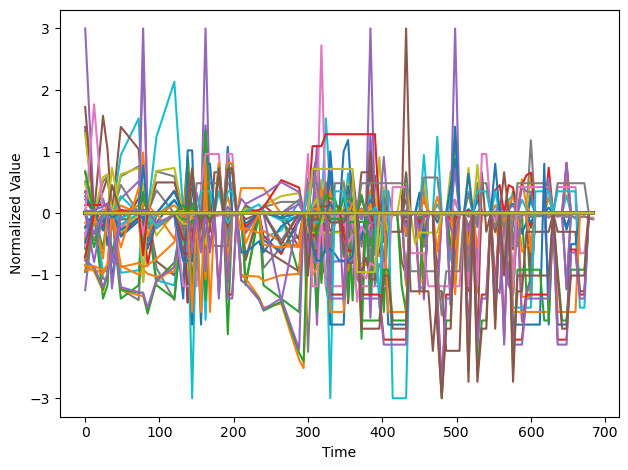

In [80]:
F = 669

for i in range(F):
    plt.plot(time_offsets_tensor, values_tensor[:, i], 
             label=f"Normalized Feature {i}")
plt.xlabel("Time")
plt.ylabel("Normalized Value")
#plt.legend()

plt.tight_layout()


In [70]:
def mimic_collate_fn(batch):
    """
    `batch` is a list of samples (dicts). We want to produce:
      physio shape = (T, BatchSize, 2*NUM_ITEMIDS)
    and keep the other items in some structure (lists or otherwise).
    """

    hadm_ids = [item['hadm_id'] for item in batch]
    physio_tensors = [item['physio_tensor'] for item in batch] 
    baseline_list = [item['baseline_df'] for item in batch]
    treatments_list = [item['treatments_df'] for item in batch]
    discharge_list = [item['discharge_df'] for item in batch]
    metadata_list = [item['metadata_df'] for item in batch]

    # Default stacking => shape (BatchSize, T, 2*NUM_ITEMIDS)
    physio_batch = torch.stack(physio_tensors, dim=0)
    
    # Transpose to get => (T, BatchSize, 2*NUM_ITEMIDS)
    physio_batch = physio_batch.transpose(0, 1)

    return {
        'hadm_ids': hadm_ids,
        'physio': physio_batch,     # shape: (T, BatchSize, 2*NUM_ITEMIDS)
        'baseline': baseline_list,
        'treatments': treatments_list,
        'discharge': discharge_list,
        'metadata': metadata_list
    }

In [24]:
import torch
import pandas as pd
categories_df = categories_df[categories_df['physio_category'] != 'unknown']

categories_df["cluster_id"], uniques = pd.factorize(categories_df["physio_category"])
print("\nData with cluster IDs:\n", categories_df)
print("\nUnique clusters:", uniques)
cluster_labels = torch.tensor(categories_df["cluster_id"].values, dtype=torch.long)
print("\nCluster labels tensor shape:", cluster_labels.shape)




Data with cluster IDs:
                                       name physio_category  cluster_id
0                   Temperature Fahrenheit       metabolic           0
1     Non Invasive Blood Pressure systolic  cardiovascular           1
2    Non Invasive Blood Pressure diastolic  cardiovascular           1
3         Non Invasive Blood Pressure mean  cardiovascular           1
4                               Heart Rate  cardiovascular           1
..                                     ...             ...         ...
618                    CD56 Absolute Count          immune          12
619                 Uric Acid, Joint Fluid       metabolic           0
620                Creatinine, Joint Fluid           renal           5
621                                  Blood   hematological          11
622                             Leukocytes   hematological          11

[623 rows x 3 columns]

Unique clusters: Index(['metabolic', 'cardiovascular', 'respiratory', 'neurological',
       'elec

In [1]:
import pandas as pd

test_hadm_id = 23559586

disch_path = '/Users/riccardoconci/Local_documents/!!MIMIC/note/discharge.csv'
discharge_df = pd.read_csv(disch_path)[['hadm_id', 'charttime', 'text']]



In [28]:
text = discharge_df[discharge_df['hadm_id'] == 24390449]['text'].iloc[0]
print(text)

 
Name:  ___                 Unit No:   ___
 
Admission Date:  ___              Discharge Date:   ___
 
Date of Birth:  ___             Sex:   M
 
Service: MEDICINE
 
Allergies: 
dust,dogs,cats,horses / Dilaudid
 
Attending: ___.
 
Chief Complaint:
Fevers, hematemesis
 
Major Surgical or Invasive Procedure:
Left IJ line placement ___ removed ___

 
History of Present Illness:
___ y/o male with ___ syndrome (with hx of 
intermittent GI and nasal bleeds), protein losing enteropathy on 
TPN, seizure disorder, ampullary adenocarcinoma s/p Whipple, 
chronic DVT s/p IVC filter on apixaban who presents with fevers 
and hemetemisis. 

Per ED note, patient states that on ___ night he began having 
fevers up to 104 associated with his chronic ___ epigastric 
pain and multiple episodes of hemetemisis. Decreased PO intake, 
malaise but normal brown stools per history. Denies ___ 
swelling, PND, orthopnea. 

At ___ ABD/Pelv - ED reported unremarkable 
(however trace ascites, hepatic cirrhosis and s

In [17]:
import re

def parse_included_sections(
    text, 
    included_headings, 
    excluded_headings, 
    case_insensitive=True
):
    """
    Scans the entire text in order of headings. At each heading:
      - If heading is in included_headings, switch 'selecting' to True.
      - If heading is in excluded_headings, switch 'selecting' to False.
      - If heading is in neither, do nothing to 'selecting'.
    While selecting=True, we collect text from the current heading until the next heading.

    Returns:
      A list of dicts, each with:
        - 'start_offset':  Start char index of this included block
        - 'end_offset':    End char index of this included block
        - 'heading':       The heading text that triggered selecting
        - 'content':       The substring from [start_offset : end_offset]
    
    Example:
      included_headings = ["History of Present Illness", "Past Medical History"]
      excluded_headings = ["Medications on Admission", "Discharge Instructions"]
      parse_included_sections(text, included_headings, excluded_headings)
    """
    all_headings = list(set(included_headings + excluded_headings))
    
    # Build the pattern
    pattern_str = "(" + "|".join(re.escape(h) for h in all_headings) + "):"
    
    # Compile case-insensitively if requested
    flags = re.IGNORECASE if case_insensitive else 0
    regex = re.compile(pattern_str, flags=flags)
    
    # 2. Find all occurrences of these headings
    matches = list(regex.finditer(text))
    # We'll add a "sentinel" at the end (len(text)) so we know where the last heading's block ends
    # This sentinel does not represent a real heading, but it ensures we capture trailing text
    # if we happen to be in selecting mode at the end.
    sentinel = type("SentinelMatch", (), {})()  # a mock object
    setattr(sentinel, "start", lambda: len(text))
    matches.append(sentinel)
    
    # Prepare sets (in lower case) for quick membership tests
    included_set = set(h.lower() for h in included_headings)
    excluded_set = set(h.lower() for h in excluded_headings)
    
    selected_blocks = []
    selecting = False
    current_heading_text = None
    
    # 3. Walk through each heading in order
    for i in range(len(matches) - 1):
        this_match = matches[i]
        next_match = matches[i+1]
        
        this_heading_start = this_match.start()
        # The next heading starts at next_match.start() (or end of text if sentinel)
        next_heading_start = next_match.start()
        
        # We can figure out exactly which heading was matched from group(0) if we want:
        # But group(1) is the parenthesized text (the heading itself, minus the colon).
        heading_matched = this_match.group(1) if hasattr(this_match, "group") else None
        
        # Compare heading in lowercase to included/excluded sets
        if heading_matched:
            heading_lower = heading_matched.lower()
            if heading_lower in included_set:
                selecting = True
                current_heading_text = heading_matched.strip()
            elif heading_lower in excluded_set:
                selecting = False
                current_heading_text = None
            else:
                # Not in included or excluded => do nothing, keep same selecting state
                pass
        
        # 4. If we are currently selecting, we capture text from
        #    this heading's start offset up to next heading's start offset.
        if selecting and heading_matched:
            block_start = this_heading_start
            block_end = next_heading_start
            
            content = text[block_start:block_end]
            
            selected_blocks.append({
                "start_offset": block_start,
                "end_offset": block_end,
                "heading": current_heading_text,
                "content": content
            })
    
    return selected_blocks

In [18]:
def highlight_sections(text, selected_blocks):
    """
    Takes the full text and a list of 'selected_blocks' (each with start_offset/end_offset/content).
    Returns an HTML string that highlights ONLY those blocks in yellow. 
    The rest of the text remains unhighlighted.
    """
    # Sort by start_offset
    blocks_sorted = sorted(selected_blocks, key=lambda b: b["start_offset"])
    
    html_parts = []
    last_pos = 0
    
    for block in blocks_sorted:
        start = block["start_offset"]
        end = block["end_offset"]
        
        # Everything from last_pos to start is normal (unhighlighted)
        html_parts.append(text[last_pos:start])
        
        # The selected block is highlighted
        html_parts.append(
            '<mark style="background-color: yellow;">'
            + text[start:end]
            + '</mark>'
        )
        
        last_pos = end
    
    # Append the remainder
    html_parts.append(text[last_pos:])
    
    html_output = (
        "<!DOCTYPE html>\n<html>\n<head>\n"
        "  <meta charset='UTF-8'>\n  <title>Highlighted Note</title>\n</head>\n"
        "<body>\n<pre style='font-family: monospace;'>\n"
        + "".join(html_parts)
        + "\n</pre>\n</body>\n</html>"
    )
    return html_output

In [19]:
section_names = [
    "History of Present Illness",
    "Past Medical History",
    "Social History",
    "Family History",
    "Physical Exam",
    "Brief Hospital Course",
    "IMPRESSION",
    "DISCHARGE PHYSICAL EXAM",
    "ACUTE/ACTIVE ISSUES",
    "Discharge Diagnosis",
]

sections_to_ignore = [
    "pertinent results", 
    "DISCHARGE LABS", 
    "Medications on Admission", 
    "Medications on Discharge", 
    "Discharge Medications", 
    "Discharge Disposition", 
    "Discharge Instructions"
]


In [20]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

def chunkify_blocks_nltk(blocks, words_per_chunk=150):
    """
    Combines the content from all blocks into a single list of words using NLTK's word_tokenize,
    and then splits the words into dense chunks each containing at most `words_per_chunk` words.

    Args:
        blocks (list of dict): Each dict must have a 'content' key with text.
        words_per_chunk (int): Maximum number of words per chunk (default: 150).

    Returns:
        list of str: A list of text chunks, where each chunk has no more than `words_per_chunk` words.
    """
    all_words = []
    for block in blocks:
        words = word_tokenize(block['content'])
        all_words.extend(words)
    
    total_words = len(all_words)
    chunks = []
    # This loop produces chunks that are exactly words_per_chunk, except possibly the final chunk
    for i in range(0, total_words, words_per_chunk):
        chunk = " ".join(all_words[i: i + words_per_chunk])
        chunks.append(chunk)
    return chunks


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/riccardoconci/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [21]:
blocks = parse_included_sections(
        text=text,
        included_headings=section_names,
        excluded_headings=sections_to_ignore,
        case_insensitive=True
    )

In [22]:
blocks

[{'start_offset': 413,
  'end_offset': 2872,
  'heading': 'History of Present Illness',
  'content': 'History of Present Illness:\nMs. ___ is a ___ year-old woman a PMH significant for AFib on \ncoumadin, UPJ obstruction s/p stent placement in ___ c/b \nchronic Klebsiella bacturia, IgG myeloma on lenolidamide, and \nadenocarcinoma of the anal canal (followed by Dr. ___ \nadmitted to ___ for evaluation of anemia (Hgb 8.6) \nwith course complicated by atrial fibrillation with RVR \nrequiring ICU admission for dilt gtt, Acute of chronic kidney \ninjury osteomyelitis from sacral decubitus ucler who was \ntransferred to ___ for debridement of sacral ulcer.  \n  In the ED she developed afib with RVR with hypotension where \nshe briefly required a dilt gtt. She was then transferred to the \nfloor. \n  Hospital course thus far has included an MRI without \nosteomyelitis, abdominal distension w/ NGT placement draining \nbilious contents, CBI and urology procedure for evaluation of \nhematuria. 

In [23]:
html_result = highlight_sections(text, blocks)
with open("highlighted_note.html", "w", encoding="utf-8") as f:
    f.write(html_result)


In [24]:
chunks = chunkify_blocks_nltk(blocks, words_per_chunk=150)
chunks

['History of Present Illness : Ms. ___ is a ___ year-old woman a PMH significant for AFib on coumadin , UPJ obstruction s/p stent placement in ___ c/b chronic Klebsiella bacturia , IgG myeloma on lenolidamide , and adenocarcinoma of the anal canal ( followed by Dr. ___ admitted to ___ for evaluation of anemia ( Hgb 8.6 ) with course complicated by atrial fibrillation with RVR requiring ICU admission for dilt gtt , Acute of chronic kidney injury osteomyelitis from sacral decubitus ucler who was transferred to ___ for debridement of sacral ulcer . In the ED she developed afib with RVR with hypotension where she briefly required a dilt gtt . She was then transferred to the floor . Hospital course thus far has included an MRI without osteomyelitis , abdominal distension w/ NGT placement draining bilious contents , CBI and urology procedure for evaluation of hematuria .',
 "She underwent cystoscopy ___ to exchange ureteral stent and found purulence behind stent . There was no etiology of he

In [25]:
len(chunks)

20

In [25]:
full_text_list = []
for i in range(100):
    full_text_list.append(discharge_df.iloc[i]['text'])

blocks_list = []
for full_text in full_text_list:
    blocks = parse_included_sections(
        text=full_text,
        included_headings=section_names,
        excluded_headings=sections_to_ignore,
        case_insensitive=True
    )
    blocks_list.append(blocks)

example_block = blocks_list[10]
example_full_text = full_text_list[10]
html_result = highlight_sections(example_full_text, example_block)

with open("highlighted_note.html", "w", encoding="utf-8") as f:
    f.write(html_result)

print("Open 'highlighted_note.html' to see the text with only included sections highlighted.")
chunks_list = [chunkify_blocks_nltk(blocks, words_per_chunk=150) for blocks in blocks_list]


In [26]:
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModelForMaskedLM

# Define the custom one-layer ConvNetMLP module
class ConvNetMLP(nn.Module):
    def __init__(self, hidden_size, final_dim, kernel_size=3):
        """
        Args:
            hidden_size (int): Dimensionality of the transformer hidden states.
            final_dim (int): Desired dimensionality of the final embedding.
            kernel_size (int): Kernel size for the Conv1D layer (default: 3).
        """
        super(ConvNetMLP, self).__init__()
        # Conv1d expects input as (batch_size, channels, sequence_length)
        self.conv1 = nn.Conv1d(
            in_channels=hidden_size,
            out_channels=hidden_size,
            kernel_size=kernel_size,
            padding=kernel_size // 2  # to preserve sequence length
        )
        self.relu = nn.ReLU()
        # Adaptive max pooling to pool over the sequence length dimension,
        # outputting one value per channel.
        self.pool = nn.AdaptiveMaxPool1d(output_size=1)
        # Fully connected layer to project to final_dim embedding.
        self.fc = nn.Linear(hidden_size, final_dim)
        
    def forward(self, hidden_states):
        """
        Args:
            hidden_states (torch.Tensor): Tensor of shape (batch_size, seq_length, hidden_size)
        Returns:
            torch.Tensor: Final embeddings of shape (batch_size, final_dim)
        """
        # Transpose to shape (batch_size, hidden_size, seq_length)
        x = hidden_states.transpose(1, 2)
        x = self.conv1(x)  # (batch_size, hidden_size, seq_length)
        x = self.relu(x)
        x = self.pool(x)   # (batch_size, hidden_size, 1)
        x = x.squeeze(-1)  # (batch_size, hidden_size)
        output = self.fc(x)  # (batch_size, final_dim)
        return output


In [ ]:
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModelForMaskedLM
import nltk
from nltk.tokenize import word_tokenize
from collections import defaultdict

# Make sure to download NLTK data if not already done.
nltk.download('punkt')

# Set device. (On MPS you might hit issues; here we try cuda first, then mps, then cpu.)
device = torch.device('cuda' if torch.cuda.is_available() 
                      else 'mps' if torch.backends.mps.is_available() 
                      else 'cpu')

###############################################################################
# 1. Define your ConvNetMLP module (unchanged)
class ConvNetMLP(nn.Module):
    def __init__(self, hidden_size, final_dim, kernel_size=3):
        """
        Args:
            hidden_size (int): Dimensionality of the transformer hidden states.
            final_dim (int): Desired dimensionality of the final embedding.
            kernel_size (int): Kernel size for the Conv1D layer (default: 3).
        """
        super(ConvNetMLP, self).__init__()
        # Conv1d expects input as (batch_size, channels, sequence_length)
        self.conv1 = nn.Conv1d(
            in_channels=hidden_size,
            out_channels=hidden_size,
            kernel_size=kernel_size,
            padding=kernel_size // 2  # to preserve sequence length
        )
        self.relu = nn.ReLU()
        self.pool = nn.AdaptiveMaxPool1d(output_size=1)
        self.fc = nn.Linear(hidden_size, final_dim)
        
    def forward(self, hidden_states):
        """
        Args:
            hidden_states (torch.Tensor): Tensor of shape (batch_size, seq_length, hidden_size)
        Returns:
            torch.Tensor: Final embeddings of shape (batch_size, final_dim)
        """
        x = hidden_states.transpose(1, 2)  # shape: (batch_size, hidden_size, seq_length)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)   # shape: (batch_size, hidden_size, 1)
        x = x.squeeze(-1)  # shape: (batch_size, hidden_size)
        return self.fc(x)  # shape: (batch_size, final_dim)


###############################################################################
# 3. Load ClinicalBERT model and tokenizer.
model_name = "medicalai/ClinicalBERT"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForMaskedLM.from_pretrained(model_name)
model.to(device)

###############################################################################
# 4. Process your discharge summaries

# Assume you have a DataFrame `discharge_df` with a column 'text'.
full_text_list = []
num_samples = 100  # Or the number you wish to process.
for i in range(num_samples):
    full_text_list.append(discharge_df.iloc[i]['text'])

# For each discharge summary, parse out the blocks using your parser function.
blocks_list = []
for full_text in full_text_list:
    blocks = parse_included_sections(
        text=full_text,
        included_headings=section_names,
        excluded_headings=sections_to_ignore,
        case_insensitive=True
    )
    blocks_list.append(blocks)

# Optional: visualize one summary
example_index = 10
example_block = blocks_list[example_index]
example_full_text = full_text_list[example_index]
html_result = highlight_sections(example_full_text, example_block)
with open("highlighted_note.html", "w", encoding="utf-8") as f:
    f.write(html_result)
print("Open 'highlighted_note.html' to see the highlighted sections for one discharge summary.")

###############################################################################
# 5. Create chunks for every discharge summary.
all_chunks = []
chunk_discharge_indices = []  # Record which discharge summary each chunk is from.
for idx, blocks in enumerate(blocks_list):
    chunks = chunkify_blocks_nltk(blocks, words_per_chunk=150)
    for chunk in chunks:
        all_chunks.append(chunk)
        chunk_discharge_indices.append(idx)
        
print(f"Total chunks generated from {num_samples} discharge summaries: {len(all_chunks)}")

###############################################################################
# 6. Process chunks in mini-batches to avoid out-of-memory issues.
batch_size = 32  # Adjust as needed.
all_embeddings = []  # To accumulate final embeddings for all chunks.

# Initialize ConvNetMLP.
hidden_size = model.config.hidden_size  # Typically 768
final_dim = 256
convnet_mlp = ConvNetMLP(hidden_size=hidden_size, final_dim=final_dim)
convnet_mlp.to(device)

model.eval()
convnet_mlp.eval()

# Process in mini-batches.
for i in range(0, len(all_chunks), batch_size):
    batch_chunks = all_chunks[i:i+batch_size]
    # Tokenize the mini-batch.
    inputs = tokenizer(batch_chunks, padding=True, truncation=True, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)
        last_hidden_states = outputs.hidden_states[-1]  # shape: (batch, seq_len, hidden_size)
        # Pass through ConvNetMLP.
        batch_embeddings = convnet_mlp(last_hidden_states)  # shape: (batch, final_dim)
    all_embeddings.append(batch_embeddings.cpu())

# Concatenate all mini-batch embeddings.
final_embeddings = torch.cat(all_embeddings, dim=0)
print("Final ConvNetMLP embeddings shape:", final_embeddings.shape)

###############################################################################
# 7. Optional: Reassemble embeddings by discharge summary.
discharge_embeddings = defaultdict(list)
for idx, emb in zip(chunk_discharge_indices, final_embeddings):
    discharge_embeddings[idx].append(emb)

# Stack embeddings per discharge summary.
for idx, emb_list in discharge_embeddings.items():
    discharge_embeddings[idx] = torch.stack(emb_list)
    print(f"Discharge summary {idx} has {discharge_embeddings[idx].shape[0]} chunk embeddings, each of dimension {discharge_embeddings[idx].shape[1]}.")

###############################################################################
# Now:
# - `final_embeddings` is a tensor of shape (total_chunks, final_dim).
# - `discharge_embeddings` is a dictionary mapping discharge summary index to a tensor of chunk embeddings.
# These embeddings are ready for use in further tasks (e.g., contrastive learning, similarity search, clustering, etc.).

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/riccardoconci/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Open 'highlighted_note.html' to see the highlighted sections for one discharge summary.


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Total chunks generated from 100 discharge summaries: 813



KeyboardInterrupt



In [ ]:
last_hidden_states.shape

torch.Size([7, 237, 768])

<Axes: >

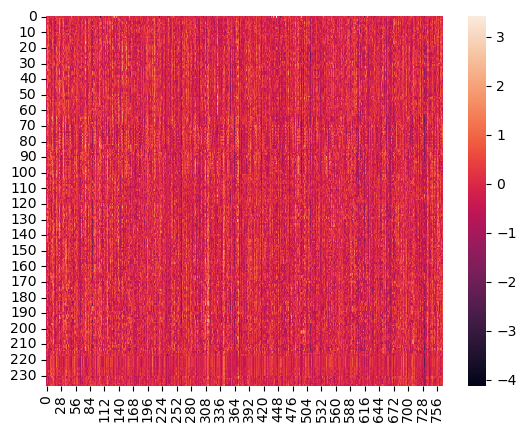

In [21]:
import seaborn as sns
sns.heatmap(last_hidden_states[1,:,:].detach().numpy())

<Axes: >

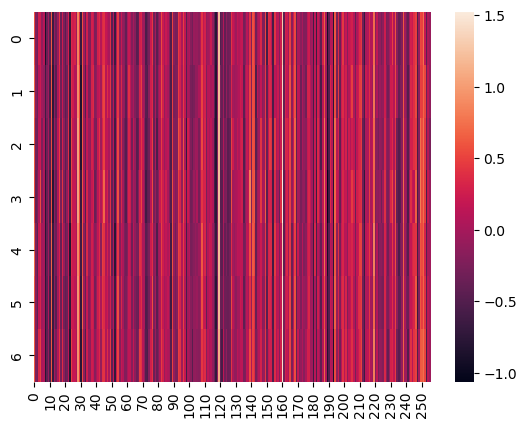

In [22]:
sns.heatmap(final_embeddings.detach().numpy())


## Labels for post-discharge experiments


1788

In [75]:
import pickle
merged_df = pickle.load(open('/Users/riccardoconci/Local_documents/!!GeomML_2025/GeomMLProj/temp_dfs_lite/merged_with_disch_df_final_filtered.pkl', 'rb'))
if merged_df.index.name != 'hadm_id':
    print("Indexing merged_with_disch_df by hadm_id...")
    merged_df.set_index('hadm_id', inplace=True)


Indexing merged_with_disch_df by hadm_id...


In [76]:
#merged_df[merged_df['hadm_id'] == 21086876]

print(f"Debug: Checking if hadm_id exists in index: {21086876 in merged_df.index}")

Debug: Checking if hadm_id exists in index: True


In [74]:
merged_df

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,...,transfer_id,eventtype,careunit,intime,outtime,admit_duration,death_timestamp,days_disch_to_death,hours_admission_to_death,days_admission_to_death
9,10000032,29079034,2180-07-23 12:35:00,2180-07-25 17:55:00,NaT,EW EMER.,P06OTX,EMERGENCY ROOM,HOME,Medicaid,...,32952584.0,ED,Emergency Department,2180-07-22 16:24:00,2180-07-23 05:54:00,2.222222,2180-09-09,45.253472,1139.416667,47.475694
10,10000032,29079034,2180-07-23 12:35:00,2180-07-25 17:55:00,NaT,EW EMER.,P06OTX,EMERGENCY ROOM,HOME,Medicaid,...,35888873.0,transfer,Transplant,2180-07-23 23:50:47,2180-07-24 19:52:58,2.222222,2180-09-09,45.253472,1139.416667,47.475694
11,10000032,29079034,2180-07-23 12:35:00,2180-07-25 17:55:00,NaT,EW EMER.,P06OTX,EMERGENCY ROOM,HOME,Medicaid,...,37434523.0,discharge,UNKNOWN,2180-07-25 17:55:43,NaN,2.222222,2180-09-09,45.253472,1139.416667,47.475694
12,10000032,29079034,2180-07-23 12:35:00,2180-07-25 17:55:00,NaT,EW EMER.,P06OTX,EMERGENCY ROOM,HOME,Medicaid,...,37682908.0,transfer,Transplant,2180-07-24 19:52:58,2180-07-25 17:55:43,2.222222,2180-09-09,45.253472,1139.416667,47.475694
13,10000032,29079034,2180-07-23 12:35:00,2180-07-25 17:55:00,NaT,EW EMER.,P06OTX,EMERGENCY ROOM,HOME,Medicaid,...,39399961.0,ED,Emergency Department,2180-07-23 05:54:00,2180-07-23 14:00:00,2.222222,2180-09-09,45.253472,1139.416667,47.475694
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2004602,19999840,26071774,2164-07-25 00:27:00,2164-07-28 12:15:00,NaT,EW EMER.,P036NA,EMERGENCY ROOM,HOME,Private,...,39694235.0,admit,Neurology,2164-07-25 01:20:00,2164-07-28 12:22:30,3.491667,2164-09-17,50.489583,1295.550000,53.981250
2004603,19999987,23865745,2145-11-02 21:38:00,2145-11-11 12:57:00,NaT,EW EMER.,P95A45,EMERGENCY ROOM,REHAB,Medicaid,...,30249304.0,transfer,Neurology,2145-11-04 21:29:30,2145-11-11 13:00:47,8.638194,NaT,NaN,NaN,NaN
2004604,19999987,23865745,2145-11-02 21:38:00,2145-11-11 12:57:00,NaT,EW EMER.,P95A45,EMERGENCY ROOM,REHAB,Medicaid,...,34731548.0,ED,Emergency Department,2145-11-02 19:28:00,2145-11-02 22:59:00,8.638194,NaT,NaN,NaN,NaN
2004605,19999987,23865745,2145-11-02 21:38:00,2145-11-11 12:57:00,NaT,EW EMER.,P95A45,EMERGENCY ROOM,REHAB,Medicaid,...,36195440.0,admit,Trauma SICU (TSICU),2145-11-02 22:59:00,2145-11-04 21:29:30,8.638194,NaT,NaN,NaN,NaN


In [ ]:
merged_df

In [9]:
merged_df.set_index('hadm_id', inplace=True)

In [10]:
merged_df.loc[29541074]

,subject_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,language,...,transfer_id,eventtype,careunit,intime,outtime,admit_duration,death_timestamp,days_disch_to_death,hours_admission_to_death,days_admission_to_death
hadm_id,,,,,,,,,,,,,,,,,,,,,
29541074,10000935,2183-10-28 09:55:00,2183-11-04 13:11:00,NaT,EW EMER.,P68RWG,EMERGENCY ROOM,HOME,Medicare,English,...,30008319.0,admit,Surgery/Trauma,2183-10-28 10:39:00,2183-11-04 13:16:13,7.136111,2187-11-12,1468.450694,35414.083333,1475.586806
29541074,10000935,2183-10-28 09:55:00,2183-11-04 13:11:00,NaT,EW EMER.,P68RWG,EMERGENCY ROOM,HOME,Medicare,English,...,31687623.0,discharge,UNKNOWN,2183-11-04 13:16:13,NaN,7.136111,2187-11-12,1468.450694,35414.083333,1475.586806
29541074,10000935,2183-10-28 09:55:00,2183-11-04 13:11:00,NaT,EW EMER.,P68RWG,EMERGENCY ROOM,HOME,Medicare,English,...,37081053.0,ED,Emergency Department,2183-10-28 03:30:00,2183-10-28 10:39:00,7.136111,2187-11-12,1468.450694,35414.083333,1475.586806


In [1]:
import os
import pickle
import pandas as pd
from typing import Tuple, Dict

def load_phecode_data(
    cache_dir: str,
    base_path: str = '/Users/riccardoconci/Local_documents/!!MIMIC/hosp/'
) -> Tuple[pd.DataFrame, Dict[str,int], Dict[int,str], int]:
    """
    Load or compute the phecode DataFrame and mappings.

    Args:
        cache_dir: directory where cached .pkl files are stored.
        base_path: location of raw MIMIC CSVs: 
            'icd_to_phecode.csv', 'diagnoses_icd.csv', 'd_icd_diagnoses.csv'

    Returns:
        phecode_df        : DataFrame indexed by hadm_id with column 'PheCode'
        phecode_to_idx    : dict mapping PheCode -> index
        idx_to_phecode    : dict mapping index -> PheCode
        phe_code_size     : int, number of unique PheCodes
    """
    # paths for cache
    mappings_pkl = os.path.join(cache_dir, "phecode_mappings.pkl")
    df_pkl       = os.path.join(cache_dir, "phecode_df.pkl")

    # 1) If mappings exist, load both mappings & df (if cached)
    if os.path.exists(mappings_pkl):
        mappings = pickle.load(open(mappings_pkl, "rb"))
        phecode_to_idx = mappings['phecode_to_idx']
        idx_to_phecode = mappings['idx_to_phecode']
        phe_code_size  = mappings['phe_code_size']

        # load df if needed
        if os.path.exists(df_pkl):
            phecode_df = pickle.load(open(df_pkl, "rb"))
        else:
            phecode_df = None

        return phecode_df, phecode_to_idx, idx_to_phecode, phe_code_size

    # 2) If df exists but mappings don't, load df and build+save mappings
    if os.path.exists(df_pkl):
        phecode_df = pickle.load(open(df_pkl, "rb"))
        unique_codes = sorted(phecode_df['PheCode'].unique())
        phecode_to_idx = {code: i for i, code in enumerate(unique_codes)}
        idx_to_phecode = {i: code for i, code in enumerate(unique_codes)}
        phe_code_size  = len(unique_codes)

        # save mappings
        pickle.dump({
            'phecode_to_idx': phecode_to_idx,
            'idx_to_phecode': idx_to_phecode,
            'phe_code_size' : phe_code_size
        }, open(mappings_pkl, "wb"))

        return phecode_df, phecode_to_idx, idx_to_phecode, phe_code_size

    # 3) Otherwise: compute phecode_df from raw CSVs
    icd_map_fp = os.path.join(base_path, 'icd_to_phecode.csv')
    diag_fp    = os.path.join(base_path, 'diagnoses_icd.csv')
    names_fp   = os.path.join(base_path, 'd_icd_diagnoses.csv')

    # read raw files
    icd_to_phe = pd.read_csv(icd_map_fp, dtype=str)
    diag_df    = pd.read_csv(diag_fp,    dtype=str)
    names_df   = pd.read_csv(names_fp,   dtype=str)

    # normalize columns
    icd_to_phe.columns = ['icd_code','PheCode','icd_version']
    icd_to_phe['icd_version'] = icd_to_phe['icd_version'].str.replace('ICD', '', regex=False)

    # merge diagnoses → phecodes
    diag_df['icd_version'] = diag_df['icd_version'].astype(str)
    merged = diag_df.merge(icd_to_phe, on=['icd_code','icd_version'], how='left')

    # attach diagnosis names (optional)
    names_df['icd_version'] = names_df['icd_version'].astype(str)
    names_df['icd_code']    = names_df['icd_code'].astype(str)
    merged = merged.merge(names_df, on=['icd_code','icd_version'], how='left')

    # filter to rows with a PheCode
    merged['has_code'] = merged['PheCode'].notna()
    phecode_df = merged[merged['has_code']].drop(columns=['has_code'])

    # cache the df
    os.makedirs(cache_dir, exist_ok=True)
    pickle.dump(phecode_df, open(df_pkl, "wb"))

    # build mappings
    unique_codes = sorted(phecode_df['PheCode'].unique())
    phecode_to_idx = {code: i for i, code in enumerate(unique_codes)}
    idx_to_phecode = {i: code for i, code in enumerate(unique_codes)}
    phe_code_size  = len(unique_codes)

    # save mappings
    pickle.dump({
        'phecode_to_idx': phecode_to_idx,
        'idx_to_phecode': idx_to_phecode,
        'phe_code_size' : phe_code_size
    }, open(mappings_pkl, "wb"))

    # index by hadm_id for fast lookup
    if phecode_df.index.name != 'hadm_id':
        phecode_df = phecode_df.set_index('hadm_id')

    return phecode_df, phecode_to_idx, idx_to_phecode, phe_code_size

In [64]:
base_path = '/Users/riccardoconci/Local_documents/!!MIMIC/hosp/'
icd_df = pd.read_csv(os.path.join(base_path, 'diagnoses_icd.csv'), dtype=str)

In [66]:
icd_df[icd_df['hadm_id'] == 29541074]

,subject_id,hadm_id,seq_num,icd_code,icd_version


In [69]:
merged_df.loc[21086876]

,subject_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,language,...,transfer_id,eventtype,careunit,intime,outtime,admit_duration,death_timestamp,days_disch_to_death,hours_admission_to_death,days_admission_to_death
hadm_id,,,,,,,,,,,,,,,,,,,,,
21086876,10000826,2146-12-18 17:39:00,2146-12-24 19:55:00,NaT,DIRECT EMER.,P61YAW,CLINIC REFERRAL,HOME,Private,English,...,33044213.0,admit,Neurology,2146-12-18 17:40:55,2146-12-23 21:33:58,6.094444,NaT,NaN,NaN,NaN
21086876,10000826,2146-12-18 17:39:00,2146-12-24 19:55:00,NaT,DIRECT EMER.,P61YAW,CLINIC REFERRAL,HOME,Private,English,...,36831600.0,discharge,UNKNOWN,2146-12-24 20:02:02,NaN,6.094444,NaT,NaN,NaN,NaN
21086876,10000826,2146-12-18 17:39:00,2146-12-24 19:55:00,NaT,DIRECT EMER.,P61YAW,CLINIC REFERRAL,HOME,Private,English,...,38387271.0,transfer,Transplant,2146-12-23 21:33:58,2146-12-24 20:02:02,6.094444,NaT,NaN,NaN,NaN


In [2]:
cache = "temp_dfs_lite"
phe_df, to_idx, to_code, code_size = load_phecode_data(cache_dir=cache)
print(f"Loaded {code_size} unique phecodes")

Loaded 1788 unique phecodes


In [57]:
phe_df['subject_id'].nunique()

223119

In [58]:
merged_df['subject_id'].nunique()

99987

In [47]:
import pandas as pd
from typing import Optional, Callable, Dict, Any

def _next_unique_admission(pa: pd.DataFrame, hadm_id: int) -> Optional[int]:
    """
    Given a patient-admissions DataFrame `pa` (with columns 'hadm_id' and 'admittime'),
    return the next distinct hadm_id after `hadm_id`, or None if there is none.
    """
    unique_ads = (
        pa[['hadm_id','admittime']]
          .drop_duplicates(subset='hadm_id')
          .sort_values('admittime')
    )
    hadm_list = unique_ads['hadm_id'].tolist()
    try:
        idx = hadm_list.index(hadm_id)
        if idx + 1 < len(hadm_list):
            return hadm_list[idx + 1]
    except ValueError:
        pass
    return None


def get_patient_labels(
    hadm_id: int,
    merged_df: pd.DataFrame,
    phecode_df: pd.DataFrame = None,
    load_phecode_df_func: Callable[[], pd.DataFrame] = None
) -> Dict[str, Any]:
    """
    Compute for a single admission:
      - mortality_6m: death within 6 months of discharge?
      - readmission_15d: next admission within 15 days?
      - current_phecodes: list of PheCodes for this hadm_id
      - next_phecodes: list of PheCodes for the next admission (if any)

    Raises:
        KeyError if hadm_id isn't present in merged_df.
    """
    # --- 0) Validate & extract this admission row ---
    if merged_df.index.name == 'hadm_id':
        if hadm_id not in merged_df.index:
            raise KeyError(f"hadm_id {hadm_id} not found in merged_df.index")
        raw = merged_df.loc[hadm_id]
    else:
        if 'hadm_id' not in merged_df.columns or hadm_id not in merged_df['hadm_id'].values:
            raise KeyError(f"hadm_id {hadm_id} not found in merged_df['hadm_id']")
        raw = merged_df[merged_df['hadm_id'] == hadm_id]

    patient_data = raw.iloc[0] if isinstance(raw, pd.DataFrame) else raw
    dischtime    = pd.to_datetime(patient_data['dischtime'])

    labels: Dict[str, Any] = {
        'mortality_6m': 0,
        'readmission_15d': 0,
        'current_phecodes': [],
        'next_phecodes': []
    }

    # ---- 1) Mortality within 6 months ----
    dod = pd.to_datetime(patient_data.get('dod'))
    if pd.notna(dod) and pd.Timedelta(0) < (dod - dischtime) <= pd.Timedelta(days=180):
        labels['mortality_6m'] = 1

    # ---- Ensure phecode_df is loaded for current admission ----
    if phecode_df is None and load_phecode_df_func:
        phecode_df = load_phecode_df_func()

    if phecode_df is not None:
        # extract codes for this hadm_id
        if phecode_df.index.name == 'hadm_id':
            if hadm_id in phecode_df.index:
                codes = phecode_df.loc[hadm_id, 'PheCode']
            else:
                codes = []
        else:
            subset = phecode_df[phecode_df['hadm_id'] == hadm_id]
            codes = subset['PheCode'] if not subset.empty else []
        labels['current_phecodes'] = pd.Series(codes).unique().tolist()

    # ---- 2) Readmission within 15 days & 3) Next admission phecodes ----
    subject_id = patient_data.get('subject_id')
    if subject_id is not None:
        # unify reset-index logic so 'hadm_id' becomes a column
        if merged_df.index.name == 'hadm_id':
            df = merged_df.reset_index()
        else:
            df = merged_df.copy()

        pa = df[df['subject_id'] == subject_id].copy()
        pa['admittime'] = pd.to_datetime(pa['admittime'])
        pa = pa.sort_values('admittime').reset_index(drop=True)

        next_hadm = _next_unique_admission(pa, hadm_id)
        if next_hadm is not None:
            # check 15-day readmission
            next_row   = pa[pa['hadm_id'] == next_hadm].iloc[0]
            next_admit = pd.to_datetime(next_row['admittime'])
            if pd.Timedelta(0) < (next_admit - dischtime) <= pd.Timedelta(days=15):
                labels['readmission_15d'] = 1

            # load phecode_df again if it wasn’t already
            if phecode_df is None and load_phecode_df_func:
                phecode_df = load_phecode_df_func()

            if phecode_df is not None:
                # extract codes for the next admission
                if phecode_df.index.name == 'hadm_id':
                    if next_hadm in phecode_df.index:
                        codes = phecode_df.loc[next_hadm, 'PheCode']
                    else:
                        codes = []
                else:
                    subset = phecode_df[phecode_df['hadm_id'] == next_hadm]
                    codes  = subset['PheCode'] if not subset.empty else []
                labels['next_phecodes'] = pd.Series(codes).unique().tolist()

    return labels

In [48]:
labels = get_patient_labels(
    hadm_id=29541074,
    merged_df=merged_df,
    phecode_df=phe_df,
    load_phecode_df_func=load_phecode_data
)


In [52]:
phe_df.loc[29541074]

KeyError: 29541074

In [49]:
labels

{'mortality_6m': 0,
 'readmission_15d': 0,
 'current_phecodes': [],
 'next_phecodes': []}

In [46]:
labels

{'mortality_6m': 0, 'readmission_15d': 0, 'next_phecodes': []}

In [18]:
merged_df[merged_df['subject_id'] == 10000935]

,subject_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,language,...,transfer_id,eventtype,careunit,intime,outtime,admit_duration,death_timestamp,days_disch_to_death,hours_admission_to_death,days_admission_to_death
hadm_id,,,,,,,,,,,,,,,,,,,,,
26381316,10000935,2187-08-23 21:22:00,2187-08-27 15:35:00,NaT,EW EMER.,P52V4D,EMERGENCY ROOM,SKILLED NURSING FACILITY,Medicare,English,...,31210178.0,discharge,UNKNOWN,2187-08-27 15:35:44,NaN,3.759028,2187-11-12,76.350694,1922.633333,80.109722
26381316,10000935,2187-08-23 21:22:00,2187-08-27 15:35:00,NaT,EW EMER.,P52V4D,EMERGENCY ROOM,SKILLED NURSING FACILITY,Medicare,English,...,32845079.0,ED,Emergency Department,2187-08-23 14:37:00,2187-08-23 22:46:00,3.759028,2187-11-12,76.350694,1922.633333,80.109722
26381316,10000935,2187-08-23 21:22:00,2187-08-27 15:35:00,NaT,EW EMER.,P52V4D,EMERGENCY ROOM,SKILLED NURSING FACILITY,Medicare,English,...,35880950.0,admit,Vascular,2187-08-23 22:46:00,2187-08-24 15:22:52,3.759028,2187-11-12,76.350694,1922.633333,80.109722
26381316,10000935,2187-08-23 21:22:00,2187-08-27 15:35:00,NaT,EW EMER.,P52V4D,EMERGENCY ROOM,SKILLED NURSING FACILITY,Medicare,English,...,37351977.0,transfer,Vascular,2187-08-24 15:22:52,2187-08-27 15:35:44,3.759028,2187-11-12,76.350694,1922.633333,80.109722
29541074,10000935,2183-10-28 09:55:00,2183-11-04 13:11:00,NaT,EW EMER.,P68RWG,EMERGENCY ROOM,HOME,Medicare,English,...,30008319.0,admit,Surgery/Trauma,2183-10-28 10:39:00,2183-11-04 13:16:13,7.136111,2187-11-12,1468.450694,35414.083333,1475.586806
29541074,10000935,2183-10-28 09:55:00,2183-11-04 13:11:00,NaT,EW EMER.,P68RWG,EMERGENCY ROOM,HOME,Medicare,English,...,31687623.0,discharge,UNKNOWN,2183-11-04 13:16:13,NaN,7.136111,2187-11-12,1468.450694,35414.083333,1475.586806
29541074,10000935,2183-10-28 09:55:00,2183-11-04 13:11:00,NaT,EW EMER.,P68RWG,EMERGENCY ROOM,HOME,Medicare,English,...,37081053.0,ED,Emergency Department,2183-10-28 03:30:00,2183-10-28 10:39:00,7.136111,2187-11-12,1468.450694,35414.083333,1475.586806


In [26]:
patient_data = merged_df.loc[29541074].iloc[0]
patient_data

subject_id                                10000935
admittime                      2183-10-28 09:55:00
dischtime                      2183-11-04 13:11:00
deathtime                                      NaT
admission_type                            EW EMER.
admit_provider_id                           P68RWG
admission_location                  EMERGENCY ROOM
discharge_location                            HOME
insurance                                 Medicare
language                                   English
marital_status                              SINGLE
race                        BLACK/AFRICAN AMERICAN
edregtime                      2183-10-28 03:30:00
edouttime                      2183-10-28 10:39:00
hospital_expire_flag                             0
gender                                           F
anchor_age                                      52
anchor_year                                   2182
anchor_year_group                      2008 - 2010
dod                            

In [27]:

df = merged_df.reset_index() if merged_df.index.name == 'hadm_id' else merged_df.copy()
pa = df[df['subject_id'] == 10000935].copy()
pa

,hadm_id,subject_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,...,transfer_id,eventtype,careunit,intime,outtime,admit_duration,death_timestamp,days_disch_to_death,hours_admission_to_death,days_admission_to_death
31,26381316,10000935,2187-08-23 21:22:00,2187-08-27 15:35:00,NaT,EW EMER.,P52V4D,EMERGENCY ROOM,SKILLED NURSING FACILITY,Medicare,...,31210178.0,discharge,UNKNOWN,2187-08-27 15:35:44,NaN,3.759028,2187-11-12,76.350694,1922.633333,80.109722
32,26381316,10000935,2187-08-23 21:22:00,2187-08-27 15:35:00,NaT,EW EMER.,P52V4D,EMERGENCY ROOM,SKILLED NURSING FACILITY,Medicare,...,32845079.0,ED,Emergency Department,2187-08-23 14:37:00,2187-08-23 22:46:00,3.759028,2187-11-12,76.350694,1922.633333,80.109722
33,26381316,10000935,2187-08-23 21:22:00,2187-08-27 15:35:00,NaT,EW EMER.,P52V4D,EMERGENCY ROOM,SKILLED NURSING FACILITY,Medicare,...,35880950.0,admit,Vascular,2187-08-23 22:46:00,2187-08-24 15:22:52,3.759028,2187-11-12,76.350694,1922.633333,80.109722
34,26381316,10000935,2187-08-23 21:22:00,2187-08-27 15:35:00,NaT,EW EMER.,P52V4D,EMERGENCY ROOM,SKILLED NURSING FACILITY,Medicare,...,37351977.0,transfer,Vascular,2187-08-24 15:22:52,2187-08-27 15:35:44,3.759028,2187-11-12,76.350694,1922.633333,80.109722
35,29541074,10000935,2183-10-28 09:55:00,2183-11-04 13:11:00,NaT,EW EMER.,P68RWG,EMERGENCY ROOM,HOME,Medicare,...,30008319.0,admit,Surgery/Trauma,2183-10-28 10:39:00,2183-11-04 13:16:13,7.136111,2187-11-12,1468.450694,35414.083333,1475.586806
36,29541074,10000935,2183-10-28 09:55:00,2183-11-04 13:11:00,NaT,EW EMER.,P68RWG,EMERGENCY ROOM,HOME,Medicare,...,31687623.0,discharge,UNKNOWN,2183-11-04 13:16:13,NaN,7.136111,2187-11-12,1468.450694,35414.083333,1475.586806
37,29541074,10000935,2183-10-28 09:55:00,2183-11-04 13:11:00,NaT,EW EMER.,P68RWG,EMERGENCY ROOM,HOME,Medicare,...,37081053.0,ED,Emergency Department,2183-10-28 03:30:00,2183-10-28 10:39:00,7.136111,2187-11-12,1468.450694,35414.083333,1475.586806


In [30]:
pa[['subject_id', 'hadm_id', 'admittime', 'dischtime']]

,subject_id,hadm_id,admittime,dischtime
0,10000935,29541074,2183-10-28 09:55:00,2183-11-04 13:11:00
1,10000935,29541074,2183-10-28 09:55:00,2183-11-04 13:11:00
2,10000935,29541074,2183-10-28 09:55:00,2183-11-04 13:11:00
3,10000935,26381316,2187-08-23 21:22:00,2187-08-27 15:35:00
4,10000935,26381316,2187-08-23 21:22:00,2187-08-27 15:35:00
5,10000935,26381316,2187-08-23 21:22:00,2187-08-27 15:35:00
6,10000935,26381316,2187-08-23 21:22:00,2187-08-27 15:35:00


In [32]:
hadm_id = 29541074

In [33]:

dischtime = pd.to_datetime(patient_data['dischtime'])
pa['admittime'] = pd.to_datetime(pa['admittime'])
pa = pa.sort_values('admittime').reset_index(drop=True)
unique_ads = (
    pa[['hadm_id','admittime']]
    .drop_duplicates(subset='hadm_id')
    .sort_values('admittime')
)
hadm_list = unique_ads['hadm_id'].tolist()

pos = hadm_list.index(hadm_id)


In [35]:
hadm_list

[29541074, 26381316]

In [29]:

# grab the next unique admission, if it exists
if pos + 1 < len(hadm_list):
    next_hadm = hadm_list[pos + 1]

    # now pull any of its rows (they’re equivalent) for times…
    next_rows = pa[pa['hadm_id'] == next_hadm]
    next_ad   = next_rows.iloc[0]

    next_admittime = pd.to_datetime(next_ad['admittime'])
    if pd.Timedelta(0) < (next_admittime - dischtime) <= pd.Timedelta(days=15):
        labels['readmission_15d'] = 1

     # ---- 3. Phecodes in the next admission ----
    next_hadm = next_ad['hadm_id']

    if phe_df.index.name == 'hadm_id':
        if next_hadm not in phe_df.index:
            # no phecodes for that admission
        codes = phe_df.loc[next_hadm, 'PheCode']
    else:
        subset = phe_df[phe_df['hadm_id'] == next_hadm]
        if subset.empty:
        codes = subset['PheCode']
    labels['next_phecodes'] = pd.Series(codes).unique().tolist()

0